# Демонстрация процесса обучения модели на примере классификации

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт необходимых библиотек для анализа
import pandas as pd
import numpy as np
from scipy.stats import skew, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Импорт необходимых библиотек для схемы обучения и проверки
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score

# Импорт необходимых алгоритмов для обучения
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
# Определение пути разработанной библиотеки
import sys
sys.path.append('../')

In [4]:
# Наша разработанная библиотека
from autobinary import NansAnalysis, base_pipe, StratifiedGroupKFold, PrimarySelection
from autobinary import AutoTrees, AutoSelection
from autobinary import FinalModel, PlotShap, PlotPDP

In [5]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('lightboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.3.4
numpy:  1.22.2
scipy:  1.7.3
sklearn:  1.1.3
lightboost:  1.0.4
matplotlib:  3.7.0
autobinary:  1.0.9


## Начало анализа

In [6]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

In [7]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns + cat_columns

target = 'Survived'

In [8]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns
)

Определены количественные и категориальные переменные!


In [9]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [10]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

Количество столбцов до: 12
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 12 


In [11]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

feature  cnt_null  share_nans
10        Cabin       687        0.77
5           Age       177        0.20
11     Embarked         2        0.00
0   PassengerId         0        0.00
1      Survived         0        0.00
2        Pclass         0        0.00
3          Name         0        0.00
4           Sex         0        0.00
6         SibSp         0        0.00
7         Parch         0        0.00
8        Ticket         0        0.00
9          Fare         0        0.00

In [12]:
# Разделим генеральную совокупность на обучающее и тестовое множества.

X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [13]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='lightboost',
                                     task_type='classification')

Класс первичного отбора факторов инициализирован!


In [14]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.4, 
                                                  drop_with_most_correlations=True)

Определены количественные и категориальные переменные!
Количество факторов до: 7
Количество факторов после корреляционного анализа: 6


In [15]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

Корреляция более 40.0%
Pclass               ['Fare']

In [16]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

metric
Sex       54.1383
Fare      38.6561
Pclass    35.5899
Embarked  17.5231
Parch     17.3706
SibSp     17.2877
Age        2.5410

In [17]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['SibSp', 'Parch', 'Embarked', 'Sex', 'Age', 'Fare']

In [18]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены количественные и категориальные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 6
Количество признаков после mean importance относительно глубины: 6
Количество признаков после mean rank относительно глубины: 6


In [19]:
feature_selection.fi.head(5)

importance_depth_1  importance_depth_2  importance_depth_3  \
Sex           9248.759086         9802.779716         9991.386434   
Fare          2676.378949         3322.974358         4341.057824   
Age              0.000000          999.698651         1670.168675   
SibSp          571.306269          770.071167          916.275160   
Parch            0.000000          151.053780          525.644644   

       mean_importance  mean_rank  
Sex        9680.975079   0.323810  
Fare       3446.803711   0.258730  
Age         889.955776   0.126984  
SibSp       752.550865   0.161905  
Parch       225.566141   0.063492

In [20]:
# задаем стратегию проверки
strat = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)

In [21]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       group=None,
                                       n_iter=30,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=roc_auc_score,
                                       higher_is_better=True)

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!
Расчет Permutation Importance на Train


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 430.41it/s]


Расчет Permutation Importance на Test


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5443.11it/s]


Perm_Importance_Tr  Perm_Importance_Te
Feature                                               
Sex                       0.239858            0.236209
Fare                      0.130268            0.071660
Age                       0.038675            0.016499
SibSp                     0.008224            0.004645
Embarked                  0.011381            0.004375
Parch                     0.008717           -0.000576
random_feature            0.062597           -0.009495

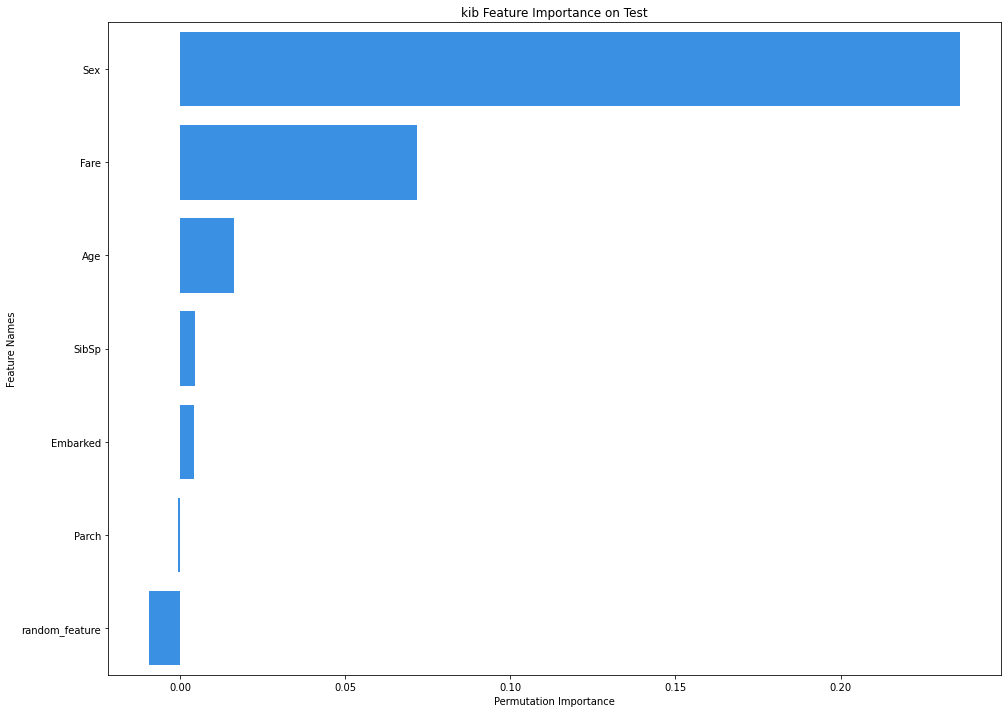

In [22]:
# Отрисовка топ факторов по Permutation Importance

feature_selection.permutation_plot(figsize=(16,12), top=10)

In [23]:
# Получаем факторы после анализа пермутейшн

features_after_permutation = feature_selection.select_features()

# Обновляем признаки
num_columns = list(filter(lambda x: x in features_after_permutation, num_columns))
cat_columns = list(filter(lambda x: x in features_after_permutation, cat_columns))

7 признаков было до Permutation Importance 

5 признаков после Permutation Importance от kib


## Расчет важностей по кросс-валидации

In [24]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [25]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [26]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [27]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.596804	training's auc: 0.902459	valid_1's binary_logloss: 0.615559	valid_1's auc: 0.797754
[50]	training's binary_logloss: 0.541732	training's auc: 0.908616	valid_1's binary_logloss: 0.578683	valid_1's auc: 0.80046
[75]	training's binary_logloss: 0.502619	training's auc: 0.91351	valid_1's binary_logloss: 0.555023	valid_1's auc: 0.796943
[100]	training's binary_logloss: 0.473245	training's auc: 0.913314	valid_1's binary_logloss: 0.536462	valid_1's auc: 0.80046
[125]	training's binary_logloss: 0.449005	training's auc: 0.915156	valid_1's binary_logloss: 0.522286	valid_1's auc: 0.805871
[150]	training's binary_logloss: 0.42755	training's auc: 0.920809	valid_1's binary_logloss: 0.512765	valid_1's auc: 0.806142
[175]	training's binary_logloss: 0.40935	training's auc: 0.924493	valid_1's binary_logloss: 0.505547	valid_1's auc: 0.807765
[200]	training's binary_logloss: 0.394286	training's auc: 0.927375

1it [00:00,  3.01it/s]

[250]	training's binary_logloss: 0.369889	training's auc: 0.933114	valid_1's binary_logloss: 0.49436	valid_1's auc: 0.809389
[275]	training's binary_logloss: 0.359267	training's auc: 0.935928	valid_1's binary_logloss: 0.493806	valid_1's auc: 0.808306
[300]	training's binary_logloss: 0.349065	training's auc: 0.938469	valid_1's binary_logloss: 0.492602	valid_1's auc: 0.812229
[325]	training's binary_logloss: 0.340747	training's auc: 0.940481	valid_1's binary_logloss: 0.49263	valid_1's auc: 0.813582
[350]	training's binary_logloss: 0.332974	training's auc: 0.942519	valid_1's binary_logloss: 0.493448	valid_1's auc: 0.815206
[375]	training's binary_logloss: 0.326479	training's auc: 0.943901	valid_1's binary_logloss: 0.493415	valid_1's auc: 0.816288
[400]	training's binary_logloss: 0.320717	training's auc: 0.945572	valid_1's binary_logloss: 0.494882	valid_1's auc: 0.814935
BEST ITERATION:  301
roc_auc на обучающей выборке: 0.939
roc_auc на проверочной выборке: 0.812

********************** 1

2it [00:00,  3.15it/s]

BEST ITERATION:  335
roc_auc на обучающей выборке: 0.934
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.597737	training's auc: 0.900106	valid_1's binary_logloss: 0.617149	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.544147	training's auc: 0.907524	valid_1's binary_logloss: 0.579806	valid_1's auc: 0.807359


3it [00:00,  3.38it/s]

[75]	training's binary_logloss: 0.507124	training's auc: 0.910909	valid_1's binary_logloss: 0.555024	valid_1's auc: 0.813718
[100]	training's binary_logloss: 0.478294	training's auc: 0.910296	valid_1's binary_logloss: 0.538607	valid_1's auc: 0.808847
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.602363	training's auc: 0.89406	valid_1's binary_logloss: 0.599565	valid_1's auc: 0.890163
[50]	training's binary_logloss: 0.551644	training's auc: 0.899218	valid_1's binary_logloss: 0.545681	valid_1's auc: 0.900111
[75]	training's binary_logloss: 0.515482	training's auc: 0.902552	valid_1's binary_logloss: 0.510946	valid_1's auc: 0.899558
[100]	training's binary_logloss: 0.487534	training's auc: 0.902424	valid_1's binary_logloss: 0.481788	valid_1's auc: 0.902874
[125]	training's binary

4it [00:01,  2.65it/s]

[350]	training's binary_logloss: 0.364965	training's auc: 0.925692	valid_1's binary_logloss: 0.379357	valid_1's auc: 0.910196
[375]	training's binary_logloss: 0.358482	training's auc: 0.927796	valid_1's binary_logloss: 0.376028	valid_1's auc: 0.911854
[400]	training's binary_logloss: 0.352879	training's auc: 0.92917	valid_1's binary_logloss: 0.374081	valid_1's auc: 0.910611
[425]	training's binary_logloss: 0.34758	training's auc: 0.930867	valid_1's binary_logloss: 0.372017	valid_1's auc: 0.911163
[450]	training's binary_logloss: 0.342371	training's auc: 0.932852	valid_1's binary_logloss: 0.370111	valid_1's auc: 0.911992
[475]	training's binary_logloss: 0.337702	training's auc: 0.934141	valid_1's binary_logloss: 0.367345	valid_1's auc: 0.912545
[500]	training's binary_logloss: 0.333117	training's auc: 0.935498	valid_1's binary_logloss: 0.366689	valid_1's auc: 0.913374
[525]	training's binary_logloss: 0.328477	training's auc: 0.937721	valid_1's binary_logloss: 0.366921	valid_1's auc: 0.9

5it [00:01,  2.87it/s]

[400]	training's binary_logloss: 0.348976	training's auc: 0.927942	valid_1's binary_logloss: 0.427659	valid_1's auc: 0.879523
BEST ITERATION:  318
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.884

********************** 5 фолд обучен! ******************************




In [28]:
model.get_mean_cv_scores()

0.8528289337342387

In [29]:
model._best_iters

[301, 335, 18, 488, 318]

In [30]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.938674   0.934436   0.896661   0.934972   0.920786
1   roc_valid   0.812500   0.834821   0.819264   0.913650   0.883909
2  gini_train  87.734707  86.887119  79.332162  86.994435  84.157204
3  gini_valid  62.500000  66.964286  63.852814  82.730036  76.781798

In [31]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  \
0       Sex   7338.110150   6956.435221   1671.821007   6432.235637   
1      Fare   4394.029037   5029.757139    709.023812   5051.479692   
2       Age   2753.129949   2662.502303    115.284780   3117.889178   
3     SibSp    844.225876    530.426621     21.886303   1264.705538   
4  Embarked    533.458165    459.241439     92.139620    743.678775   

   importance 4  mean_importance  
0   7046.843279      5889.089059  
1   3936.689969      3824.195930  
2   2506.831584      2231.127559  
3    565.811764       645.411221  
4    663.839323       498.471464

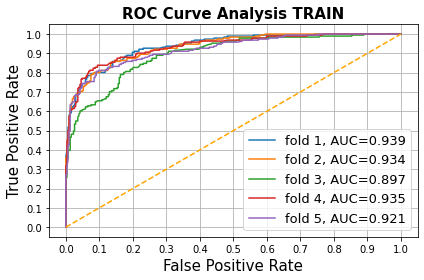

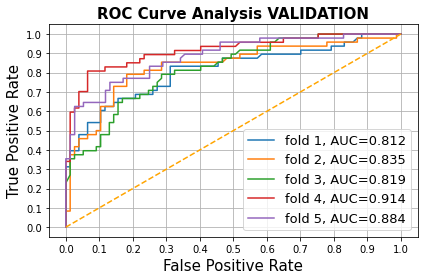

In [32]:
model.get_rocauc_plots()

In [33]:
model.get_curve_plots()

## Жадные отборы Forward и Backward selection

In [34]:
selection = AutoSelection(base_pipe=base_pipe,
                          num_columns=num_columns,
                          cat_columns=cat_columns,
                          main_fit_params=fit_params,
                          main_estimator=lgb_model,
                          
                          X_train=X_train,
                          y_train=y_train,
                          main_metric='roc_auc',
                          model_type='lightboost')

Определены количественные и категориальные переменные!


In [35]:
fselection_res = selection.forward_selection(strat=strat)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.596804	training's auc: 0.902459	valid_1's binary_logloss: 0.615559	valid_1's auc: 0.797754
[50]	training's binary_logloss: 0.541732	training's auc: 0.908616	valid_1's binary_logloss: 0.578683	valid_1's auc: 0.80046
[75]	training's binary_logloss: 0.502619	training's auc: 0.91351	valid_1's binary_logloss: 0.555023	valid_1's auc: 0.796943
[100]	training's binary_logloss: 0.473245	training's auc: 0.913314	valid_1's binary_logloss: 0.536462	valid_1's auc: 0.80046
[125]	training's binary_logloss: 0.449005	training's auc: 0.915156	valid_1's binary_logloss: 0.522286	valid_1's auc: 0.805871
[150]	training's binary_logloss: 0.42755	training's auc: 0.920809	valid_1's binary_logloss: 0.512765	valid_1's auc: 0.806142
[175]	training's binary_logloss: 0.40935	training's auc: 0.924493	valid_1's binary_logloss: 0.505547	valid_1's auc: 0.807765
[200]	training's binary_logloss: 0.394286	training's auc: 0.927375

1it [00:00,  1.29it/s]

[300]	training's binary_logloss: 0.349065	training's auc: 0.938469	valid_1's binary_logloss: 0.492602	valid_1's auc: 0.812229
[325]	training's binary_logloss: 0.340747	training's auc: 0.940481	valid_1's binary_logloss: 0.49263	valid_1's auc: 0.813582
[350]	training's binary_logloss: 0.332974	training's auc: 0.942519	valid_1's binary_logloss: 0.493448	valid_1's auc: 0.815206
[375]	training's binary_logloss: 0.326479	training's auc: 0.943901	valid_1's binary_logloss: 0.493415	valid_1's auc: 0.816288
[400]	training's binary_logloss: 0.320717	training's auc: 0.945572	valid_1's binary_logloss: 0.494882	valid_1's auc: 0.814935
BEST ITERATION:  301
roc_auc на обучающей выборке: 0.939
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.598094	training's auc: 0.899713	valid_1's binary_logloss: 0.61789	valid_1's auc: 0.811688
[50]	training's bina

2it [00:01,  1.80it/s]

[425]	training's binary_logloss: 0.330484	training's auc: 0.941036	valid_1's binary_logloss: 0.482407	valid_1's auc: 0.832927
BEST ITERATION:  335
roc_auc на обучающей выборке: 0.934
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.597737	training's auc: 0.900106	valid_1's binary_logloss: 0.617149	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.544147	training's auc: 0.907524	valid_1's binary_logloss: 0.579806	valid_1's auc: 0.807359
[75]	training's binary_logloss: 0.507124	training's auc: 0.910909	valid_1's binary_logloss: 0.555024	valid_1's auc: 0.813718
[100]	training's binary_logloss: 0.478294	training's auc: 0.910296	valid_1's binary_logloss: 0.538607	valid_1's auc: 0.808847


3it [00:01,  2.55it/s]

BEST ITERATION:  18
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.602363	training's auc: 0.89406	valid_1's binary_logloss: 0.599565	valid_1's auc: 0.890163
[50]	training's binary_logloss: 0.551644	training's auc: 0.899218	valid_1's binary_logloss: 0.545681	valid_1's auc: 0.900111
[75]	training's binary_logloss: 0.515482	training's auc: 0.902552	valid_1's binary_logloss: 0.510946	valid_1's auc: 0.899558
[100]	training's binary_logloss: 0.487534	training's auc: 0.902424	valid_1's binary_logloss: 0.481788	valid_1's auc: 0.902874
[125]	training's binary_logloss: 0.464851	training's auc: 0.903425	valid_1's binary_logloss: 0.458386	valid_1's auc: 0.903565
[150]	training's binary_logloss: 0.446277	training's auc: 0.90636	valid_1's binary_logloss: 0.442458	valid_1's auc: 0.905775
[175]	training's binary

4it [00:01,  2.39it/s]

[550]	training's binary_logloss: 0.324399	training's auc: 0.939095	valid_1's binary_logloss: 0.365633	valid_1's auc: 0.910887
[575]	training's binary_logloss: 0.320071	training's auc: 0.940791	valid_1's binary_logloss: 0.36444	valid_1's auc: 0.910887
BEST ITERATION:  488
roc_auc на обучающей выборке: 0.935
roc_auc на проверочной выборке: 0.914

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.599812	training's auc: 0.886262	valid_1's binary_logloss: 0.608782	valid_1's auc: 0.861431
[50]	training's binary_logloss: 0.548868	training's auc: 0.89165	valid_1's binary_logloss: 0.564886	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.512842	training's auc: 0.895636	valid_1's binary_logloss: 0.535756	valid_1's auc: 0.866639
[100]	training's binary_logloss: 0.484796	training's auc: 0.897234	valid_1's binary_logloss: 0.513281	valid_1's auc: 0.865132
[125]	training's binar

5it [00:02,  2.37it/s]


[225]	training's binary_logloss: 0.405124	training's auc: 0.911012	valid_1's binary_logloss: 0.452416	valid_1's auc: 0.878975
[250]	training's binary_logloss: 0.394946	training's auc: 0.913919	valid_1's binary_logloss: 0.446175	valid_1's auc: 0.879249
[275]	training's binary_logloss: 0.386068	training's auc: 0.916587	valid_1's binary_logloss: 0.442189	valid_1's auc: 0.879523
[300]	training's binary_logloss: 0.377494	training's auc: 0.919579	valid_1's binary_logloss: 0.43762	valid_1's auc: 0.88199
[325]	training's binary_logloss: 0.369719	training's auc: 0.921568	valid_1's binary_logloss: 0.433802	valid_1's auc: 0.882812
[350]	training's binary_logloss: 0.361963	training's auc: 0.924118	valid_1's binary_logloss: 0.431876	valid_1's auc: 0.880071
[375]	training's binary_logloss: 0.355667	training's auc: 0.926302	valid_1's binary_logloss: 0.431065	valid_1's auc: 0.879249
[400]	training's binary_logloss: 0.348976	training's auc: 0.927942	valid_1's binary_logloss: 0.427659	valid_1's auc: 0.8

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 14.96it/s]

[25]	training's binary_logloss: 0.607059	training's auc: 0.768653	valid_1's binary_logloss: 0.604705	valid_1's auc: 0.778815
[50]	training's binary_logloss: 0.571424	training's auc: 0.768653	valid_1's binary_logloss: 0.567001	valid_1's auc: 0.778815
[75]	training's binary_logloss: 0.549282	training's auc: 0.768653	valid_1's binary_logloss: 0.54317	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.603428	training's auc: 0.776157	valid_1's binary_logloss: 0.610683	valid_1's auc: 0.748918
[50]	training's binary_logloss: 0.565563	training's auc: 0.776157	valid_1's binary_logloss: 0.578507	valid_1's auc: 0.748918
[75]	training's binary_logl

4it [00:00, 13.83it/s]

[100]	training's binary_logloss: 0.527148	training's auc: 0.776157	valid_1's binary_logloss: 0.548597	valid_1's auc: 0.748918
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.776
roc_auc на проверочной выборке: 0.749

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.612717	training's auc: 0.756786	valid_1's binary_logloss: 0.59383	valid_1's auc: 0.826886
[50]	training's binary_logloss: 0.580202	training's auc: 0.756786	valid_1's binary_logloss: 0.548518	valid_1's auc: 0.826886
[75]	training's binary_logloss: 0.560061	training's auc: 0.756786	valid_1's binary_logloss: 0.518094	valid_1's auc: 0.826886
[100]	training's binary_logloss: 0.547483	training's auc: 0.756786	valid_1's binary_logloss: 0.497208	valid_1's auc: 0.826886
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! *****************

5it [00:00, 14.12it/s]


[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846
Добавление признака Fare
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.609082	training's auc: 0.863363	valid_1's binary_logloss: 0.619579	valid_1's auc: 0.795455


1it [00:00,  8.01it/s]

[50]	training's binary_logloss: 0.567416	training's auc: 0.863951	valid_1's binary_logloss: 0.58747	valid_1's auc: 0.796537
[75]	training's binary_logloss: 0.536705	training's auc: 0.863695	valid_1's binary_logloss: 0.565268	valid_1's auc: 0.798701
[100]	training's binary_logloss: 0.513059	training's auc: 0.865836	valid_1's binary_logloss: 0.548403	valid_1's auc: 0.803571
[125]	training's binary_logloss: 0.4949	training's auc: 0.86859	valid_1's binary_logloss: 0.535788	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.48042	training's auc: 0.868812	valid_1's binary_logloss: 0.525222	valid_1's auc: 0.800595
[175]	training's binary_logloss: 0.469367	training's auc: 0.869784	valid_1's binary_logloss: 0.518391	valid_1's auc: 0.80276
[200]	training's binary_logloss: 0.460606	training's auc: 0.871574	valid_1's binary_logloss: 0.513754	valid_1's auc: 0.800054
BEST ITERATION:  103
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.804

********************** 1 фолд 

2it [00:00,  6.37it/s]

[275]	training's binary_logloss: 0.440105	training's auc: 0.878063	valid_1's binary_logloss: 0.498379	valid_1's auc: 0.827516
[300]	training's binary_logloss: 0.434643	training's auc: 0.87849	valid_1's binary_logloss: 0.496244	valid_1's auc: 0.828328
[325]	training's binary_logloss: 0.429939	training's auc: 0.879573	valid_1's binary_logloss: 0.495007	valid_1's auc: 0.823728
BEST ITERATION:  243
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.608012	training's auc: 0.877339	valid_1's binary_logloss: 0.629129	valid_1's auc: 0.753382
[50]	training's binary_logloss: 0.565362	training's auc: 0.878063	valid_1's binary_logloss: 0.601532	valid_1's auc: 0.754735
[75]	training's binary_logloss: 0.533669	training's auc: 0.880152	valid_1's binary_logloss: 0.582425	valid_1's auc: 0.757035
[100]	training's bina

4it [00:00,  8.14it/s]

[175]	training's binary_logloss: 0.491104	training's auc: 0.856924	valid_1's binary_logloss: 0.447537	valid_1's auc: 0.90163
[200]	training's binary_logloss: 0.482245	training's auc: 0.859859	valid_1's binary_logloss: 0.437375	valid_1's auc: 0.900525
BEST ITERATION:  105
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.610899	training's auc: 0.853369	valid_1's binary_logloss: 0.615724	valid_1's auc: 0.836897
[50]	training's binary_logloss: 0.570808	training's auc: 0.854899	valid_1's binary_logloss: 0.578196	valid_1's auc: 0.8358
[75]	training's binary_logloss: 0.542024	training's auc: 0.857245	valid_1's binary_logloss: 0.552522	valid_1's auc: 0.83443
[100]	training's binary_logloss: 0.519891	training's auc: 0.85784	valid_1's binary_logloss: 0.532884	valid_1's auc: 0.82881


5it [00:00,  8.25it/s]


BEST ITERATION:  11
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.844

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.8329604384510597
Добавление признака Age
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.594775	training's auc: 0.864787	valid_1's binary_logloss: 0.621003	valid_1's auc: 0.719832
[50]	training's binary_logloss: 0.546013	training's auc: 0.885482	valid_1's binary_logloss: 0.591123	valid_1's auc: 0.750271
[75]	training's binary_logloss: 0.508462	training's auc: 0.890982	valid_1's binary_logloss: 0.56958	valid_1's auc: 0.762175
[100]	training's binary_logloss: 0.480726	training's auc: 0.892576	valid_1's binary_logloss: 0.555097	valid_1's auc: 0.763799
[125]	training's binary_logloss: 0.457487	training's auc: 0.9002	valid_1's binary_logloss: 0.541528	valid_1's auc: 0.775027
[150]	training's binary_logloss: 0.43908	training's auc: 0.904531	valid_1's binary_logloss: 0.531794	valid_1's auc: 0.782332
[175]	training's binary_logloss: 0.426223	training's auc: 0.90581	valid_1's binary_logloss: 0.525819	valid_1's auc: 0.787879
[200]	training's binary_logloss: 0.416481	training's auc: 0.906339

1it [00:00,  3.24it/s]

[425]	training's binary_logloss: 0.359684	training's auc: 0.924655	valid_1's binary_logloss: 0.514545	valid_1's auc: 0.800325
BEST ITERATION:  333
roc_auc на обучающей выборке: 0.919
roc_auc на проверочной выборке: 0.803

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.597995	training's auc: 0.857573	valid_1's binary_logloss: 0.608375	valid_1's auc: 0.790314
[50]	training's binary_logloss: 0.552325	training's auc: 0.880383	valid_1's binary_logloss: 0.576427	valid_1's auc: 0.802624
[75]	training's binary_logloss: 0.518507	training's auc: 0.887358	valid_1's binary_logloss: 0.553297	valid_1's auc: 0.804924
[100]	training's binary_logloss: 0.492293	training's auc: 0.890308	valid_1's binary_logloss: 0.534839	valid_1's auc: 0.805195
[125]	training's binary_logloss: 0.470558	training's auc: 0.895365	valid_1's binary_logloss: 0.522518	valid_1's auc: 0.809659
[150]	training's bin

2it [00:00,  4.49it/s]

roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.812

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.00it/s]

[25]	training's binary_logloss: 0.596901	training's auc: 0.857249	valid_1's binary_logloss: 0.606491	valid_1's auc: 0.8079
[50]	training's binary_logloss: 0.55173	training's auc: 0.881756	valid_1's binary_logloss: 0.575879	valid_1's auc: 0.796943
[75]	training's binary_logloss: 0.516959	training's auc: 0.889251	valid_1's binary_logloss: 0.551906	valid_1's auc: 0.803571
[100]	training's binary_logloss: 0.490285	training's auc: 0.894648	valid_1's binary_logloss: 0.534443	valid_1's auc: 0.803571
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.60056	training's auc: 0.85532	valid_1's binary_logloss: 0.5896	valid_1's auc: 0.854518
[50]	training's binary_logloss: 0.557727	training's auc: 0.87338	valid_1's binary_logloss: 0.542656	valid_1's auc: 0.865432
[75]	training's binary_logloss: 

4it [00:00,  4.87it/s]

roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.889

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.593719	training's auc: 0.867784	valid_1's binary_logloss: 0.608546	valid_1's auc: 0.786184
[50]	training's binary_logloss: 0.548428	training's auc: 0.883814	valid_1's binary_logloss: 0.573601	valid_1's auc: 0.794134
[75]	training's binary_logloss: 0.515297	training's auc: 0.885905	valid_1's binary_logloss: 0.548648	valid_1's auc: 0.798657
[100]	training's binary_logloss: 0.490229	training's auc: 0.88627	valid_1's binary_logloss: 0.532238	valid_1's auc: 0.800027
[125]	training's binary_logloss: 0.470878	training's auc: 0.890367	valid_1's binary_logloss: 0.51885	valid_1's auc: 0.805373
[150]	training's binary_logloss: 0.455054	training's auc: 0.894098	valid_1's binary_logloss: 0.508906	valid_1's auc: 0.815515
[175]	training's binary_logloss: 0.443534	t

5it [00:01,  4.24it/s]


[625]	training's binary_logloss: 0.357755	training's auc: 0.918857	valid_1's binary_logloss: 0.470564	valid_1's auc: 0.832237
BEST ITERATION:  536
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.836

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.8305476275311101
Добавление признака SibSp
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.591883	training's auc: 0.886377	valid_1's binary_logloss: 0.610533	valid_1's auc: 0.801542
[50]	training's binary_logloss: 0.543174	training's auc: 0.889208	valid_1's binary_logloss: 0.576579	valid_1's auc: 0.806953
[75]	training's binary_logloss: 0.504594	training's auc: 0.894785	valid_1's binary_logloss: 0.552197	valid_1's auc: 0.808712
[100]	training's binary_logloss: 0.476245	training's auc: 0.89875	valid_1's binary_logloss: 0.536023	valid_1's auc: 0.809253
[125]	training's binary_logloss: 0.454965	training's auc: 0.90251	valid_1's binary_logloss: 0.524954	valid_1's auc: 0.809794
[150]	training's binary_logloss: 0.437249	training's auc: 0.904753	valid_1's binary_logloss: 0.516136	valid_1's auc: 0.808442
[175]	training's binary_logloss: 0.421767	training's auc: 0.909076	valid_1's binary_logloss: 0.511295	valid_1's auc: 0.808847
[200]	training's binary_logloss: 0.40797	training's auc: 0.9138

1it [00:00,  5.51it/s]

BEST ITERATION:  113
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.593488	training's auc: 0.885354	valid_1's binary_logloss: 0.608706	valid_1's auc: 0.830898
[50]	training's binary_logloss: 0.546199	training's auc: 0.889166	valid_1's binary_logloss: 0.572977	valid_1's auc: 0.825758
[75]	training's binary_logloss: 0.509089	training's auc: 0.888995	valid_1's binary_logloss: 0.545437	valid_1's auc: 0.824946
[100]	training's binary_logloss: 0.482043	training's auc: 0.892662	valid_1's binary_logloss: 0.527909	valid_1's auc: 0.818994
BEST ITERATION:  16


2it [00:00,  6.18it/s]

roc_auc на обучающей выборке: 0.880
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.59178	training's auc: 0.899168	valid_1's binary_logloss: 0.610843	valid_1's auc: 0.787473
[50]	training's binary_logloss: 0.543283	training's auc: 0.900131	valid_1's binary_logloss: 0.577426	valid_1's auc: 0.789096
[75]	training's binary_logloss: 0.505348	training's auc: 0.901683	valid_1's binary_logloss: 0.552749	valid_1's auc: 0.79099
[100]	training's binary_logloss: 0.477912	training's auc: 0.904514	valid_1's binary_logloss: 0.536304	valid_1's auc: 0.794778
[125]	training's binary_logloss: 0.458875	training's auc: 0.90581	valid_1's binary_logloss: 0.528147	valid_1's auc: 0.792749
[150]	training's binary_logloss: 0.44137	training's auc: 0.908769	valid_1's binary_logloss: 0.518829	valid_1's auc: 0.794372
[175]	training's binary_logloss: 0.427037	tra

3it [00:00,  4.30it/s]

[500]	training's binary_logloss: 0.339629	training's auc: 0.934487	valid_1's binary_logloss: 0.493252	valid_1's auc: 0.817776
BEST ITERATION:  406
roc_auc на обучающей выборке: 0.928
roc_auc на проверочной выборке: 0.820

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.599317	training's auc: 0.874924	valid_1's binary_logloss: 0.589617	valid_1's auc: 0.889058
[50]	training's binary_logloss: 0.553667	training's auc: 0.882906	valid_1's binary_logloss: 0.540461	valid_1's auc: 0.890578
[75]	training's binary_logloss: 0.519146	training's auc: 0.885586	valid_1's binary_logloss: 0.502103	valid_1's auc: 0.894722
[100]	training's binary_logloss: 0.492277	training's auc: 0.888623	valid_1's binary_logloss: 0.47405	valid_1's auc: 0.902183
[125]	training's binary_logloss: 0.473029	training's auc: 0.891923	valid_1's binary_logloss: 0.454749	valid_1's auc: 0.903288
[150]	training's bina

4it [00:00,  3.70it/s]

roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.905

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.595975	training's auc: 0.87834	valid_1's binary_logloss: 0.603097	valid_1's auc: 0.86335
[50]	training's binary_logloss: 0.548824	training's auc: 0.88412	valid_1's binary_logloss: 0.56139	valid_1's auc: 0.865543
[75]	training's binary_logloss: 0.512735	training's auc: 0.886177	valid_1's binary_logloss: 0.529084	valid_1's auc: 0.871299
[100]	training's binary_logloss: 0.485629	training's auc: 0.889746	valid_1's binary_logloss: 0.507756	valid_1's auc: 0.871162
[125]	training's binary_logloss: 0.467411	training's auc: 0.889729	valid_1's binary_logloss: 0.493598	valid_1's auc: 0.868969
[150]	training's binary_logloss: 0.451146	training's auc: 0.891472	valid_1's binary_logloss: 0.479883	valid_1's auc: 0.871985
[175]	training's binary_logloss: 0.436764	tra

5it [00:01,  4.23it/s]


roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.873

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8489237858306307
Добавление признака Embarked
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.36it/s]

[25]	training's binary_logloss: 0.597197	training's auc: 0.907422	valid_1's binary_logloss: 0.615577	valid_1's auc: 0.797213
[50]	training's binary_logloss: 0.542017	training's auc: 0.914977	valid_1's binary_logloss: 0.578919	valid_1's auc: 0.802354
[75]	training's binary_logloss: 0.501709	training's auc: 0.916256	valid_1's binary_logloss: 0.553029	valid_1's auc: 0.80533
[100]	training's binary_logloss: 0.471708	training's auc: 0.916179	valid_1's binary_logloss: 0.534056	valid_1's auc: 0.809389
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.874
roc_auc на проверочной выборке: 0.820

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.600955	training's auc: 0.897658	valid_1's binary_logloss: 0.617323	valid_1's auc: 0.827381
[50]	training's binary_logloss: 0.549091	training's auc: 0.90211	valid_1's binary_logloss: 0.582025	valid_1's auc: 0.816017
[75]	training's binary_log

2it [00:00,  5.94it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.856

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.600482	training's auc: 0.900174	valid_1's binary_logloss: 0.617063	valid_1's auc: 0.820346
[50]	training's binary_logloss: 0.548583	training's auc: 0.906552	valid_1's binary_logloss: 0.57938	valid_1's auc: 0.821293
[75]	training's binary_logloss: 0.509569	training's auc: 0.911046	valid_1's binary_logloss: 0.555317	valid_1's auc: 0.816964
[100]	training's binary_logloss: 0.480235	training's auc: 0.910986	valid_1's binary_logloss: 0.538176	valid_1's auc: 0.812635
BEST ITERATION:  12


3it [00:00,  6.16it/s]

roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.830

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  5.70it/s]

[25]	training's binary_logloss: 0.605026	training's auc: 0.892847	valid_1's binary_logloss: 0.602562	valid_1's auc: 0.886295
[50]	training's binary_logloss: 0.555104	training's auc: 0.898692	valid_1's binary_logloss: 0.55173	valid_1's auc: 0.893479
[75]	training's binary_logloss: 0.516925	training's auc: 0.90273	valid_1's binary_logloss: 0.511755	valid_1's auc: 0.90315
[100]	training's binary_logloss: 0.488686	training's auc: 0.902255	valid_1's binary_logloss: 0.482299	valid_1's auc: 0.902597
[125]	training's binary_logloss: 0.466356	training's auc: 0.903994	valid_1's binary_logloss: 0.459608	valid_1's auc: 0.904808
[150]	training's binary_logloss: 0.447216	training's auc: 0.90832	valid_1's binary_logloss: 0.444287	valid_1's auc: 0.903703
[175]	training's binary_logloss: 0.430605	training's auc: 0.909931	valid_1's binary_logloss: 0.430239	valid_1's auc: 0.90315
[200]	training's binary_logloss: 0.418082	training's auc: 0.911229	valid_1's binary_logloss: 0.418697	valid_1's auc: 0.903979


5it [00:00,  5.28it/s]

[25]	training's binary_logloss: 0.601985	training's auc: 0.892594	valid_1's binary_logloss: 0.611028	valid_1's auc: 0.868284
[50]	training's binary_logloss: 0.551399	training's auc: 0.897073	valid_1's binary_logloss: 0.56782	valid_1's auc: 0.874315
[75]	training's binary_logloss: 0.514186	training's auc: 0.898773	valid_1's binary_logloss: 0.53775	valid_1's auc: 0.868832
[100]	training's binary_logloss: 0.485997	training's auc: 0.899181	valid_1's binary_logloss: 0.514742	valid_1's auc: 0.868969
[125]	training's binary_logloss: 0.463627	training's auc: 0.900235	valid_1's binary_logloss: 0.497392	valid_1's auc: 0.866639
BEST ITERATION:  28
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.875

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.8573175034418735

Количество отобранных признаков: 5
Метрика до отбора: 0.8528 => после отбора: 0.8573
Конец жадного отбора факторов Forward Selection!


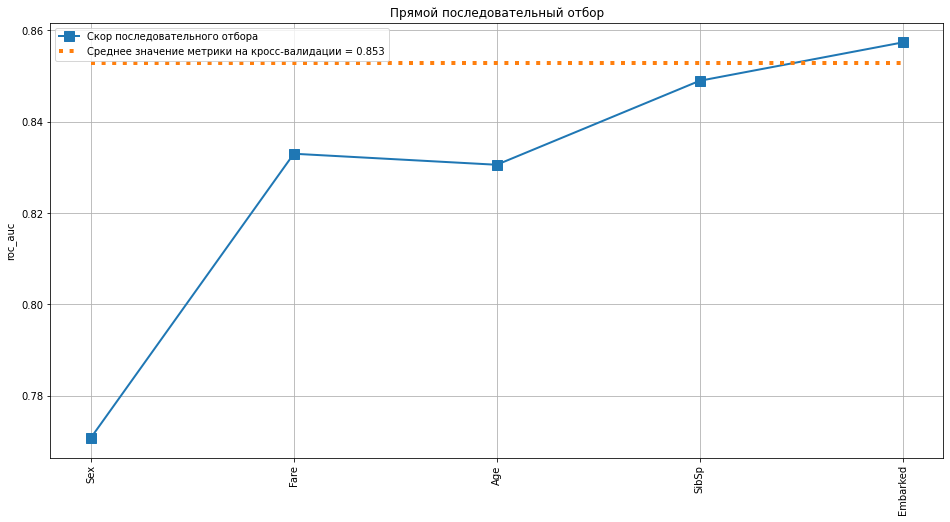

In [36]:
selection.plot_forward(figsize=(16,8))

In [37]:
bselection_res = selection.backward_selection(strat=strat,first_degradation=False)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.596804	training's auc: 0.902459	valid_1's binary_logloss: 0.615559	valid_1's auc: 0.797754
[50]	training's binary_logloss: 0.541732	training's auc: 0.908616	valid_1's binary_logloss: 0.578683	valid_1's auc: 0.80046
[75]	training's binary_logloss: 0.502619	training's auc: 0.91351	valid_1's binary_logloss: 0.555023	valid_1's auc: 0.796943
[100]	training's binary_logloss: 0.473245	training's auc: 0.913314	valid_1's binary_logloss: 0.536462	valid_1's auc: 0.80046
[125]	training's binary_logloss: 0.449005	training's auc: 0.915156	valid_1's binary_logloss: 0.522286	valid_1's auc: 0.805871
[150]	training's binary_logloss: 0.42755	training's auc: 0.920809	valid_1's binary_logloss: 0.512765	valid_1's auc: 0.806142
[175]	training's binary_logloss: 0.40935	training's auc: 0.924493	valid_1's binary_logloss: 0.505547	valid_1's auc: 0.807765
[200]	training's binary_logloss: 0.394286	training's auc: 0.927375

1it [00:00,  3.78it/s]

[350]	training's binary_logloss: 0.332974	training's auc: 0.942519	valid_1's binary_logloss: 0.493448	valid_1's auc: 0.815206
[375]	training's binary_logloss: 0.326479	training's auc: 0.943901	valid_1's binary_logloss: 0.493415	valid_1's auc: 0.816288
[400]	training's binary_logloss: 0.320717	training's auc: 0.945572	valid_1's binary_logloss: 0.494882	valid_1's auc: 0.814935
BEST ITERATION:  301
roc_auc на обучающей выборке: 0.939
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.598094	training's auc: 0.899713	valid_1's binary_logloss: 0.61789	valid_1's auc: 0.811688
[50]	training's binary_logloss: 0.544341	training's auc: 0.904514	valid_1's binary_logloss: 0.582314	valid_1's auc: 0.809253
[75]	training's binary_logloss: 0.507578	training's auc: 0.906262	valid_1's binary_logloss: 0.555617	valid_1's auc: 0.820752
[100]	training's bina

2it [00:00,  2.54it/s]

[375]	training's binary_logloss: 0.341755	training's auc: 0.937872	valid_1's binary_logloss: 0.482884	valid_1's auc: 0.832927
[400]	training's binary_logloss: 0.336037	training's auc: 0.939552	valid_1's binary_logloss: 0.482454	valid_1's auc: 0.833198
[425]	training's binary_logloss: 0.330484	training's auc: 0.941036	valid_1's binary_logloss: 0.482407	valid_1's auc: 0.832927
BEST ITERATION:  335
roc_auc на обучающей выборке: 0.934
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:01,  2.82it/s]

[25]	training's binary_logloss: 0.597737	training's auc: 0.900106	valid_1's binary_logloss: 0.617149	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.544147	training's auc: 0.907524	valid_1's binary_logloss: 0.579806	valid_1's auc: 0.807359
[75]	training's binary_logloss: 0.507124	training's auc: 0.910909	valid_1's binary_logloss: 0.555024	valid_1's auc: 0.813718
[100]	training's binary_logloss: 0.478294	training's auc: 0.910296	valid_1's binary_logloss: 0.538607	valid_1's auc: 0.808847
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.602363	training's auc: 0.89406	valid_1's binary_logloss: 0.599565	valid_1's auc: 0.890163
[50]	training's binary_logloss: 0.551644	training's auc: 0.899218	valid_1's binary_logloss: 0.545681	valid_1's auc: 0.900111
[75]	training's binary_l

4it [00:01,  1.94it/s]

[350]	training's binary_logloss: 0.364965	training's auc: 0.925692	valid_1's binary_logloss: 0.379357	valid_1's auc: 0.910196
[375]	training's binary_logloss: 0.358482	training's auc: 0.927796	valid_1's binary_logloss: 0.376028	valid_1's auc: 0.911854
[400]	training's binary_logloss: 0.352879	training's auc: 0.92917	valid_1's binary_logloss: 0.374081	valid_1's auc: 0.910611
[425]	training's binary_logloss: 0.34758	training's auc: 0.930867	valid_1's binary_logloss: 0.372017	valid_1's auc: 0.911163
[450]	training's binary_logloss: 0.342371	training's auc: 0.932852	valid_1's binary_logloss: 0.370111	valid_1's auc: 0.911992
[475]	training's binary_logloss: 0.337702	training's auc: 0.934141	valid_1's binary_logloss: 0.367345	valid_1's auc: 0.912545
[500]	training's binary_logloss: 0.333117	training's auc: 0.935498	valid_1's binary_logloss: 0.366689	valid_1's auc: 0.913374
[525]	training's binary_logloss: 0.328477	training's auc: 0.937721	valid_1's binary_logloss: 0.366921	valid_1's auc: 0.9

5it [00:02,  2.40it/s]


[25]	training's binary_logloss: 0.599812	training's auc: 0.886262	valid_1's binary_logloss: 0.608782	valid_1's auc: 0.861431
[50]	training's binary_logloss: 0.548868	training's auc: 0.89165	valid_1's binary_logloss: 0.564886	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.512842	training's auc: 0.895636	valid_1's binary_logloss: 0.535756	valid_1's auc: 0.866639
[100]	training's binary_logloss: 0.484796	training's auc: 0.897234	valid_1's binary_logloss: 0.513281	valid_1's auc: 0.865132
[125]	training's binary_logloss: 0.462984	training's auc: 0.898892	valid_1's binary_logloss: 0.494888	valid_1's auc: 0.867188
[150]	training's binary_logloss: 0.445515	training's auc: 0.901518	valid_1's binary_logloss: 0.480381	valid_1's auc: 0.872396
[175]	training's binary_logloss: 0.430125	training's auc: 0.903991	valid_1's binary_logloss: 0.469944	valid_1's auc: 0.874315
[200]	training's binary_logloss: 0.41667	training's auc: 0.907145	valid_1's binary_logloss: 0.459215	valid_1's auc: 0.8781

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.47it/s]

[25]	training's binary_logloss: 0.591883	training's auc: 0.886377	valid_1's binary_logloss: 0.610533	valid_1's auc: 0.801542
[50]	training's binary_logloss: 0.543174	training's auc: 0.889208	valid_1's binary_logloss: 0.576579	valid_1's auc: 0.806953
[75]	training's binary_logloss: 0.504594	training's auc: 0.894785	valid_1's binary_logloss: 0.552197	valid_1's auc: 0.808712
[100]	training's binary_logloss: 0.476245	training's auc: 0.89875	valid_1's binary_logloss: 0.536023	valid_1's auc: 0.809253
[125]	training's binary_logloss: 0.454965	training's auc: 0.90251	valid_1's binary_logloss: 0.524954	valid_1's auc: 0.809794
[150]	training's binary_logloss: 0.437249	training's auc: 0.904753	valid_1's binary_logloss: 0.516136	valid_1's auc: 0.808442
[175]	training's binary_logloss: 0.421767	training's auc: 0.909076	valid_1's binary_logloss: 0.511295	valid_1's auc: 0.808847
[200]	training's binary_logloss: 0.40797	training's auc: 0.91386	valid_1's binary_logloss: 0.507887	valid_1's auc: 0.808577

2it [00:00,  6.70it/s]

roc_auc на обучающей выборке: 0.880
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.59178	training's auc: 0.899168	valid_1's binary_logloss: 0.610843	valid_1's auc: 0.787473
[50]	training's binary_logloss: 0.543283	training's auc: 0.900131	valid_1's binary_logloss: 0.577426	valid_1's auc: 0.789096
[75]	training's binary_logloss: 0.505348	training's auc: 0.901683	valid_1's binary_logloss: 0.552749	valid_1's auc: 0.79099
[100]	training's binary_logloss: 0.477912	training's auc: 0.904514	valid_1's binary_logloss: 0.536304	valid_1's auc: 0.794778
[125]	training's binary_logloss: 0.458875	training's auc: 0.90581	valid_1's binary_logloss: 0.528147	valid_1's auc: 0.792749
[150]	training's binary_logloss: 0.44137	training's auc: 0.908769	valid_1's binary_logloss: 0.518829	valid_1's auc: 0.794372
[175]	training's binary_logloss: 0.427037	tra

3it [00:00,  4.64it/s]

[350]	training's binary_logloss: 0.368649	training's auc: 0.923871	valid_1's binary_logloss: 0.489961	valid_1's auc: 0.818182
[375]	training's binary_logloss: 0.363827	training's auc: 0.925593	valid_1's binary_logloss: 0.488381	valid_1's auc: 0.818452
[400]	training's binary_logloss: 0.35858	training's auc: 0.927051	valid_1's binary_logloss: 0.488315	valid_1's auc: 0.818858
[425]	training's binary_logloss: 0.352929	training's auc: 0.929473	valid_1's binary_logloss: 0.489368	valid_1's auc: 0.820211
[450]	training's binary_logloss: 0.347795	training's auc: 0.931315	valid_1's binary_logloss: 0.489928	valid_1's auc: 0.819399
[475]	training's binary_logloss: 0.343393	training's auc: 0.933003	valid_1's binary_logloss: 0.492412	valid_1's auc: 0.817505
[500]	training's binary_logloss: 0.339629	training's auc: 0.934487	valid_1's binary_logloss: 0.493252	valid_1's auc: 0.817776
BEST ITERATION:  406
roc_auc на обучающей выборке: 0.928
roc_auc на проверочной выборке: 0.820

********************** 

4it [00:00,  4.62it/s]

[100]	training's binary_logloss: 0.492277	training's auc: 0.888623	valid_1's binary_logloss: 0.47405	valid_1's auc: 0.902183
[125]	training's binary_logloss: 0.473029	training's auc: 0.891923	valid_1's binary_logloss: 0.454749	valid_1's auc: 0.903288
[150]	training's binary_logloss: 0.45699	training's auc: 0.892355	valid_1's binary_logloss: 0.436639	valid_1's auc: 0.90163
[175]	training's binary_logloss: 0.4438	training's auc: 0.896164	valid_1's binary_logloss: 0.425177	valid_1's auc: 0.902736
[200]	training's binary_logloss: 0.432049	training's auc: 0.898734	valid_1's binary_logloss: 0.415837	valid_1's auc: 0.904393
[225]	training's binary_logloss: 0.422316	training's auc: 0.901593	valid_1's binary_logloss: 0.40868	valid_1's auc: 0.904117
[250]	training's binary_logloss: 0.414015	training's auc: 0.903569	valid_1's binary_logloss: 0.402499	valid_1's auc: 0.901907
[275]	training's binary_logloss: 0.406721	training's auc: 0.905665	valid_1's binary_logloss: 0.397574	valid_1's auc: 0.90080

5it [00:01,  5.00it/s]


[100]	training's binary_logloss: 0.485629	training's auc: 0.889746	valid_1's binary_logloss: 0.507756	valid_1's auc: 0.871162
[125]	training's binary_logloss: 0.467411	training's auc: 0.889729	valid_1's binary_logloss: 0.493598	valid_1's auc: 0.868969
[150]	training's binary_logloss: 0.451146	training's auc: 0.891472	valid_1's binary_logloss: 0.479883	valid_1's auc: 0.871985
[175]	training's binary_logloss: 0.436764	training's auc: 0.895704	valid_1's binary_logloss: 0.470954	valid_1's auc: 0.868284
BEST ITERATION:  77
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.873

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8489237858306307
Удаление признака 1
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.594775	training's auc: 0.864787	valid_1's binary_logloss: 0.621003	valid_1's auc: 0.719832
[50]	training's binary_logloss: 0.546013	training's auc: 0.885482	valid_1's binary_logloss: 0.591123	valid_1's auc: 0.750271
[75]	training's binary_logloss: 0.508462	training's auc: 0.890982	valid_1's binary_logloss: 0.56958	valid_1's auc: 0.762175
[100]	training's binary_logloss: 0.480726	training's auc: 0.892576	valid_1's binary_logloss: 0.555097	valid_1's auc: 0.763799
[125]	training's binary_logloss: 0.457487	training's auc: 0.9002	valid_1's binary_logloss: 0.541528	valid_1's auc: 0.775027
[150]	training's binary_logloss: 0.43908	training's auc: 0.904531	valid_1's binary_logloss: 0.531794	valid_1's auc: 0.782332
[175]	training's binary_logloss: 0.426223	training's auc: 0.90581	valid_1's binary_logloss: 0.525819	valid_1's auc: 0.787879
[200]	training's binary_logloss: 0.416481	training's auc: 0.906339

1it [00:00,  3.96it/s]

[400]	training's binary_logloss: 0.364079	training's auc: 0.922447	valid_1's binary_logloss: 0.515877	valid_1's auc: 0.801136
[425]	training's binary_logloss: 0.359684	training's auc: 0.924655	valid_1's binary_logloss: 0.514545	valid_1's auc: 0.800325
BEST ITERATION:  333
roc_auc на обучающей выборке: 0.919
roc_auc на проверочной выборке: 0.803

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.597995	training's auc: 0.857573	valid_1's binary_logloss: 0.608375	valid_1's auc: 0.790314
[50]	training's binary_logloss: 0.552325	training's auc: 0.880383	valid_1's binary_logloss: 0.576427	valid_1's auc: 0.802624
[75]	training's binary_logloss: 0.518507	training's auc: 0.887358	valid_1's binary_logloss: 0.553297	valid_1's auc: 0.804924
[100]	training's binary_logloss: 0.492293	training's auc: 0.890308	valid_1's binary_logloss: 0.534839	valid_1's auc: 0.805195
[125]	training's bin

2it [00:00,  4.69it/s]

BEST ITERATION:  136
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.812

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.596901	training's auc: 0.857249	valid_1's binary_logloss: 0.606491	valid_1's auc: 0.8079
[50]	training's binary_logloss: 0.55173	training's auc: 0.881756	valid_1's binary_logloss: 0.575879	valid_1's auc: 0.796943
[75]	training's binary_logloss: 0.516959	training's auc: 0.889251	valid_1's binary_logloss: 0.551906	valid_1's auc: 0.803571
[100]	training's binary_logloss: 0.490285	training's auc: 0.894648	valid_1's binary_logloss: 0.534443	valid_1's auc: 0.803571
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.60056	training's

4it [00:00,  5.03it/s]

[475]	training's binary_logloss: 0.392378	training's auc: 0.90491	valid_1's binary_logloss: 0.40283	valid_1's auc: 0.884775
BEST ITERATION:  387
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.889

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.593719	training's auc: 0.867784	valid_1's binary_logloss: 0.608546	valid_1's auc: 0.786184
[50]	training's binary_logloss: 0.548428	training's auc: 0.883814	valid_1's binary_logloss: 0.573601	valid_1's auc: 0.794134
[75]	training's binary_logloss: 0.515297	training's auc: 0.885905	valid_1's binary_logloss: 0.548648	valid_1's auc: 0.798657
[100]	training's binary_logloss: 0.490229	training's auc: 0.88627	valid_1's binary_logloss: 0.532238	valid_1's auc: 0.800027
[125]	training's binary_logloss: 0.470878	training's auc: 0.890367	valid_1's binary_logloss: 0.51885	valid_1's auc: 0.805373
[150]	training's binary_

5it [00:01,  4.23it/s]


[625]	training's binary_logloss: 0.357755	training's auc: 0.918857	valid_1's binary_logloss: 0.470564	valid_1's auc: 0.832237
BEST ITERATION:  536
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.836

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.8305476275311101
Удаление признака 2
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.609082	training's auc: 0.863363	valid_1's binary_logloss: 0.619579	valid_1's auc: 0.795455
[50]	training's binary_logloss: 0.567416	training's auc: 0.863951	valid_1's binary_logloss: 0.58747	valid_1's auc: 0.796537
[75]	training's binary_logloss: 0.536705	training's auc: 0.863695	valid_1's binary_logloss: 0.565268	valid_1's auc: 0.798701
[100]	training's binary_logloss: 0.513059	training's auc: 0.865836	valid_1's binary_logloss: 0.548403	valid_1's auc: 0.803571
[125]	training's binary_logloss: 0.4949	training's auc: 0.86859	valid_1's binary_logloss: 0.535788	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.48042	training's auc: 0.868812	valid_1's binary_logloss: 0.525222	valid_1's auc: 0.800595
[175]	training's binary_logloss: 0.469367	training's auc: 0.869784	valid_1's binary_logloss: 0.518391	valid_1's auc: 0.80276


1it [00:00,  7.34it/s]

[200]	training's binary_logloss: 0.460606	training's auc: 0.871574	valid_1's binary_logloss: 0.513754	valid_1's auc: 0.800054
BEST ITERATION:  103
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.804

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.610394	training's auc: 0.866552	valid_1's binary_logloss: 0.622115	valid_1's auc: 0.814935
[50]	training's binary_logloss: 0.569365	training's auc: 0.867694	valid_1's binary_logloss: 0.589244	valid_1's auc: 0.818452
[75]	training's binary_logloss: 0.538938	training's auc: 0.868308	valid_1's binary_logloss: 0.565768	valid_1's auc: 0.817911
[100]	training's binary_logloss: 0.5153	training's auc: 0.869929	valid_1's binary_logloss: 0.546735	valid_1's auc: 0.824675
[125]	training's binary_logloss: 0.497418	training's auc: 0.869622	valid_1's binary_logloss: 0.532977	valid_1's auc: 0.824946
[150]	training's binar

2it [00:00,  6.18it/s]

roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.829

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.608012	training's auc: 0.877339	valid_1's binary_logloss: 0.629129	valid_1's auc: 0.753382
[50]	training's binary_logloss: 0.565362	training's auc: 0.878063	valid_1's binary_logloss: 0.601532	valid_1's auc: 0.754735
[75]	training's binary_logloss: 0.533669	training's auc: 0.880152	valid_1's binary_logloss: 0.582425	valid_1's auc: 0.757035
[100]	training's binary_logloss: 0.508929	training's auc: 0.880187	valid_1's binary_logloss: 0.568399	valid_1's auc: 0.762581
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.784

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.615772	training's auc: 0.851418	va

4it [00:00,  7.99it/s]

roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.610899	training's auc: 0.853369	valid_1's binary_logloss: 0.615724	valid_1's auc: 0.836897
[50]	training's binary_logloss: 0.570808	training's auc: 0.854899	valid_1's binary_logloss: 0.578196	valid_1's auc: 0.8358
[75]	training's binary_logloss: 0.542024	training's auc: 0.857245	valid_1's binary_logloss: 0.552522	valid_1's auc: 0.83443
[100]	training's binary_logloss: 0.519891	training's auc: 0.85784	valid_1's binary_logloss: 0.532884	valid_1's auc: 0.82881
BEST ITERATION:  11


5it [00:00,  8.22it/s]


roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.844

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.8329604384510597
Удаление признака 3
Определены только категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.607059	training's auc: 0.768653	valid_1's binary_logloss: 0.604705	valid_1's auc: 0.778815
[50]	training's binary_logloss: 0.571424	training's auc: 0.768653	valid_1's binary_logloss

2it [00:00, 14.35it/s]

[75]	training's binary_logloss: 0.549282	training's auc: 0.768653	valid_1's binary_logloss: 0.54317	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.603428	training's auc: 0.776157	valid_1's binary_logloss: 0.610683	valid_1's auc: 0.748918
[50]	training's binary_logloss: 0.565563	training's auc: 0.776157	valid_1's binary_logloss: 0.578507	valid_1's auc: 0.748918
[75]	training's binary_logloss: 0.541979	training's auc: 0.776157	valid_1's binary_logloss: 0.559589	valid_1's auc: 0.748918
[100]	training's binary_logloss: 0.527148	training's auc: 0.776157	valid_1's binary_logloss: 0.548597	valid_1's auc: 0.748918
BEST ITERATION:  1


4it [00:00, 15.11it/s]

roc_auc на обучающей выборке: 0.776
roc_auc на проверочной выборке: 0.749

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.612717	training's auc: 0.756786	valid_1's binary_logloss: 0.59383	valid_1's auc: 0.826886
[50]	training's binary_logloss: 0.580202	training's auc: 0.756786	valid_1's binary_logloss: 0.548518	valid_1's auc: 0.826886
[75]	training's binary_logloss: 0.560061	training's auc: 0.756786	valid_1's binary_logloss: 0.518094	valid_1's auc: 0.826886
[100]	training's binary_logloss: 0.547483	training's auc: 0.756786	valid_1's binary_logloss: 0.497208	valid_1's auc: 0.826886
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	val

5it [00:00, 14.85it/s]

[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846

Количество отобранных признаков: 1
Метрика до отбора: 0.8528 => после отбора: 0.8528
Конец жадного отбора факторов Backward Selection!


In [38]:
deep_bselection_res = selection.deep_backward_selection(strat=strat,tol=0.0001)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.596804	training's auc: 0.902459	valid_1's binary_logloss: 0.615559	valid_1's auc: 0.797754
[50]	training's binary_logloss: 0.541732	training's auc: 0.908616	valid_1's binary_logloss: 0.578683	valid_1's auc: 0.80046
[75]	training's binary_logloss: 0.502619	training's auc: 0.91351	valid_1's binary_logloss: 0.555023	valid_1's auc: 0.796943
[100]	training's binary_logloss: 0.473245	training's auc: 0.913314	valid_1's binary_logloss: 0.536462	valid_1's auc: 0.80046
[125]	training's binary_logloss: 0.449005	training's auc: 0.915156	valid_1's binary_logloss: 0.522286	valid_1's auc: 0.805871
[150]	training's binary_logloss: 0.42755	training's auc: 0.920809	valid_1's binary_logloss: 0.512765	valid_1's auc: 0.806142
[175]	training's binary_logloss: 0.40935	training's auc: 0.924493	valid_1's binary_logloss: 0.505547	valid_1's auc: 0.807765
[200]	training's binary_logloss: 0.394286	training's auc: 0.927375

1it [00:00,  3.21it/s]

roc_auc на обучающей выборке: 0.939
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.598094	training's auc: 0.899713	valid_1's binary_logloss: 0.61789	valid_1's auc: 0.811688
[50]	training's binary_logloss: 0.544341	training's auc: 0.904514	valid_1's binary_logloss: 0.582314	valid_1's auc: 0.809253
[75]	training's binary_logloss: 0.507578	training's auc: 0.906262	valid_1's binary_logloss: 0.555617	valid_1's auc: 0.820752
[100]	training's binary_logloss: 0.479172	training's auc: 0.906484	valid_1's binary_logloss: 0.53404	valid_1's auc: 0.82941
[125]	training's binary_logloss: 0.455642	training's auc: 0.907857	valid_1's binary_logloss: 0.51903	valid_1's auc: 0.830492
[150]	training's binary_logloss: 0.43657	training's auc: 0.912606	valid_1's binary_logloss: 0.509623	valid_1's auc: 0.830222
[175]	training's binary_logloss: 0.419929	trai

2it [00:00,  3.34it/s]

[300]	training's binary_logloss: 0.363945	training's auc: 0.931673	valid_1's binary_logloss: 0.484853	valid_1's auc: 0.832657
[325]	training's binary_logloss: 0.356201	training's auc: 0.933839	valid_1's binary_logloss: 0.4844	valid_1's auc: 0.83428
[350]	training's binary_logloss: 0.348583	training's auc: 0.935467	valid_1's binary_logloss: 0.48397	valid_1's auc: 0.833198
[375]	training's binary_logloss: 0.341755	training's auc: 0.937872	valid_1's binary_logloss: 0.482884	valid_1's auc: 0.832927
[400]	training's binary_logloss: 0.336037	training's auc: 0.939552	valid_1's binary_logloss: 0.482454	valid_1's auc: 0.833198
[425]	training's binary_logloss: 0.330484	training's auc: 0.941036	valid_1's binary_logloss: 0.482407	valid_1's auc: 0.832927
BEST ITERATION:  335
roc_auc на обучающей выборке: 0.934
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binar

3it [00:00,  4.29it/s]

BEST ITERATION:  18
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.602363	training's auc: 0.89406	valid_1's binary_logloss: 0.599565	valid_1's auc: 0.890163
[50]	training's binary_logloss: 0.551644	training's auc: 0.899218	valid_1's binary_logloss: 0.545681	valid_1's auc: 0.900111
[75]	training's binary_logloss: 0.515482	training's auc: 0.902552	valid_1's binary_logloss: 0.510946	valid_1's auc: 0.899558
[100]	training's binary_logloss: 0.487534	training's auc: 0.902424	valid_1's binary_logloss: 0.481788	valid_1's auc: 0.902874
[125]	training's binary_logloss: 0.464851	training's auc: 0.903425	valid_1's binary_logloss: 0.458386	valid_1's auc: 0.903565
[150]	training's binary_logloss: 0.446277	training's auc: 0.90636	valid_1's binary_logloss: 0.442458	valid_1's auc: 0.905775
[175]	training's binary

4it [00:01,  3.39it/s]

[575]	training's binary_logloss: 0.320071	training's auc: 0.940791	valid_1's binary_logloss: 0.36444	valid_1's auc: 0.910887
BEST ITERATION:  488
roc_auc на обучающей выборке: 0.935
roc_auc на проверочной выборке: 0.914

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.599812	training's auc: 0.886262	valid_1's binary_logloss: 0.608782	valid_1's auc: 0.861431
[50]	training's binary_logloss: 0.548868	training's auc: 0.89165	valid_1's binary_logloss: 0.564886	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.512842	training's auc: 0.895636	valid_1's binary_logloss: 0.535756	valid_1's auc: 0.866639
[100]	training's binary_logloss: 0.484796	training's auc: 0.897234	valid_1's binary_logloss: 0.513281	valid_1's auc: 0.865132
[125]	training's binary_logloss: 0.462984	training's auc: 0.898892	valid_1's binary_logloss: 0.494888	valid_1's auc: 0.867188
[150]	training's binar

5it [00:01,  3.54it/s]


[225]	training's binary_logloss: 0.405124	training's auc: 0.911012	valid_1's binary_logloss: 0.452416	valid_1's auc: 0.878975
[250]	training's binary_logloss: 0.394946	training's auc: 0.913919	valid_1's binary_logloss: 0.446175	valid_1's auc: 0.879249
[275]	training's binary_logloss: 0.386068	training's auc: 0.916587	valid_1's binary_logloss: 0.442189	valid_1's auc: 0.879523
[300]	training's binary_logloss: 0.377494	training's auc: 0.919579	valid_1's binary_logloss: 0.43762	valid_1's auc: 0.88199
[325]	training's binary_logloss: 0.369719	training's auc: 0.921568	valid_1's binary_logloss: 0.433802	valid_1's auc: 0.882812
[350]	training's binary_logloss: 0.361963	training's auc: 0.924118	valid_1's binary_logloss: 0.431876	valid_1's auc: 0.880071
[375]	training's binary_logloss: 0.355667	training's auc: 0.926302	valid_1's binary_logloss: 0.431065	valid_1's auc: 0.879249
[400]	training's binary_logloss: 0.348976	training's auc: 0.927942	valid_1's binary_logloss: 0.427659	valid_1's auc: 0.8

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.591883	training's auc: 0.886377	valid_1's binary_logloss: 0.610533	valid_1's auc: 0.801542
[50]	training's binary_logloss: 0.543174	training's auc: 0.889208	valid_1's binary_logloss: 0.576579	valid_1's auc: 0.806953
[75]	training's binary_logloss: 0.504594	training's auc: 0.894785	valid_1's binary_logloss: 0.552197	valid_1's auc: 0.808712


1it [00:00,  5.59it/s]

[100]	training's binary_logloss: 0.476245	training's auc: 0.89875	valid_1's binary_logloss: 0.536023	valid_1's auc: 0.809253
[125]	training's binary_logloss: 0.454965	training's auc: 0.90251	valid_1's binary_logloss: 0.524954	valid_1's auc: 0.809794
[150]	training's binary_logloss: 0.437249	training's auc: 0.904753	valid_1's binary_logloss: 0.516136	valid_1's auc: 0.808442
[175]	training's binary_logloss: 0.421767	training's auc: 0.909076	valid_1's binary_logloss: 0.511295	valid_1's auc: 0.808847
[200]	training's binary_logloss: 0.40797	training's auc: 0.91386	valid_1's binary_logloss: 0.507887	valid_1's auc: 0.808577
BEST ITERATION:  113
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.593488	training's auc: 0.885354	valid_1's binary_logloss: 0.608706	valid_1's auc: 0.830898
[50]	training's binary

2it [00:00,  7.07it/s]

BEST ITERATION:  16
roc_auc на обучающей выборке: 0.880
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.59178	training's auc: 0.899168	valid_1's binary_logloss: 0.610843	valid_1's auc: 0.787473
[50]	training's binary_logloss: 0.543283	training's auc: 0.900131	valid_1's binary_logloss: 0.577426	valid_1's auc: 0.789096
[75]	training's binary_logloss: 0.505348	training's auc: 0.901683	valid_1's binary_logloss: 0.552749	valid_1's auc: 0.79099
[100]	training's binary_logloss: 0.477912	training's auc: 0.904514	valid_1's binary_logloss: 0.536304	valid_1's auc: 0.794778
[125]	training's binary_logloss: 0.458875	training's auc: 0.90581	valid_1's binary_logloss: 0.528147	valid_1's auc: 0.792749
[150]	training's binary_logloss: 0.44137	training's auc: 0.908769	valid_1's binary_logloss: 0.518829	valid_1's auc: 0.794372
[175]	training's binary_l

3it [00:00,  4.53it/s]

[475]	training's binary_logloss: 0.343393	training's auc: 0.933003	valid_1's binary_logloss: 0.492412	valid_1's auc: 0.817505
[500]	training's binary_logloss: 0.339629	training's auc: 0.934487	valid_1's binary_logloss: 0.493252	valid_1's auc: 0.817776
BEST ITERATION:  406
roc_auc на обучающей выборке: 0.928
roc_auc на проверочной выборке: 0.820

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.599317	training's auc: 0.874924	valid_1's binary_logloss: 0.589617	valid_1's auc: 0.889058
[50]	training's binary_logloss: 0.553667	training's auc: 0.882906	valid_1's binary_logloss: 0.540461	valid_1's auc: 0.890578
[75]	training's binary_logloss: 0.519146	training's auc: 0.885586	valid_1's binary_logloss: 0.502103	valid_1's auc: 0.894722
[100]	training's binary_logloss: 0.492277	training's auc: 0.888623	valid_1's binary_logloss: 0.47405	valid_1's auc: 0.902183
[125]	training's bina

4it [00:00,  4.53it/s]

[225]	training's binary_logloss: 0.422316	training's auc: 0.901593	valid_1's binary_logloss: 0.40868	valid_1's auc: 0.904117
[250]	training's binary_logloss: 0.414015	training's auc: 0.903569	valid_1's binary_logloss: 0.402499	valid_1's auc: 0.901907
[275]	training's binary_logloss: 0.406721	training's auc: 0.905665	valid_1's binary_logloss: 0.397574	valid_1's auc: 0.900801
[300]	training's binary_logloss: 0.399554	training's auc: 0.908328	valid_1's binary_logloss: 0.393797	valid_1's auc: 0.898867
BEST ITERATION:  203
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.905

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.12it/s]


[25]	training's binary_logloss: 0.595975	training's auc: 0.87834	valid_1's binary_logloss: 0.603097	valid_1's auc: 0.86335
[50]	training's binary_logloss: 0.548824	training's auc: 0.88412	valid_1's binary_logloss: 0.56139	valid_1's auc: 0.865543
[75]	training's binary_logloss: 0.512735	training's auc: 0.886177	valid_1's binary_logloss: 0.529084	valid_1's auc: 0.871299
[100]	training's binary_logloss: 0.485629	training's auc: 0.889746	valid_1's binary_logloss: 0.507756	valid_1's auc: 0.871162
[125]	training's binary_logloss: 0.467411	training's auc: 0.889729	valid_1's binary_logloss: 0.493598	valid_1's auc: 0.868969
[150]	training's binary_logloss: 0.451146	training's auc: 0.891472	valid_1's binary_logloss: 0.479883	valid_1's auc: 0.871985
[175]	training's binary_logloss: 0.436764	training's auc: 0.895704	valid_1's binary_logloss: 0.470954	valid_1's auc: 0.868284
BEST ITERATION:  77
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.873

********************** 5 фолд 

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.591633	training's auc: 0.891775	valid_1's binary_logloss: 0.61059	valid_1's auc: 0.799513
[50]	training's binary_logloss: 0.542616	training's auc: 0.895271	valid_1's binary_logloss: 0.577089	valid_1's auc: 0.802219
[75]	training's binary_logloss: 0.503759	training's auc: 0.898707	valid_1's binary_logloss: 0.552383	valid_1's auc: 0.806412
[100]	training's binary_logloss: 0.475928	training's auc: 0.901922	valid_1's binary_logloss: 0.537123	valid_1's auc: 0.803436
[125]	training's binary_logloss: 0.456201	training's auc: 0.904028	valid_1's binary_logloss: 0.525305	valid_1's auc: 0.806412
[150]	training's binary_logloss: 0.438934	training's auc: 0.905324	valid_1's binary_logloss: 0.517724	valid_1's auc: 0.80533


1it [00:00,  6.07it/s]

[175]	training's binary_logloss: 0.425201	training's auc: 0.9083	valid_1's binary_logloss: 0.514606	valid_1's auc: 0.802624
[200]	training's binary_logloss: 0.413322	training's auc: 0.910441	valid_1's binary_logloss: 0.512683	valid_1's auc: 0.799919
BEST ITERATION:  113
roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.807

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.16it/s]

[25]	training's binary_logloss: 0.592888	training's auc: 0.890794	valid_1's binary_logloss: 0.608513	valid_1's auc: 0.821429
[50]	training's binary_logloss: 0.54485	training's auc: 0.892551	valid_1's binary_logloss: 0.572387	valid_1's auc: 0.820076
[75]	training's binary_logloss: 0.507583	training's auc: 0.893335	valid_1's binary_logloss: 0.544726	valid_1's auc: 0.820346
[100]	training's binary_logloss: 0.4796	training's auc: 0.898272	valid_1's binary_logloss: 0.526106	valid_1's auc: 0.823323
BEST ITERATION:  16
roc_auc на обучающей выборке: 0.885
roc_auc на проверочной выборке: 0.835

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.591319	training's auc: 0.900421	valid_1's binary_logloss: 0.610535	valid_1's auc: 0.792343
[50]	training's binary_logloss: 0.541961	training's auc: 0.902749	valid_1's binary_logloss: 0.576908	valid_1's auc: 0.794778
[75]	training's binary_log

3it [00:00,  5.65it/s]

[225]	training's binary_logloss: 0.399176	training's auc: 0.917936	valid_1's binary_logloss: 0.503231	valid_1's auc: 0.811959
[250]	training's binary_logloss: 0.390289	training's auc: 0.919795	valid_1's binary_logloss: 0.502258	valid_1's auc: 0.812229
[275]	training's binary_logloss: 0.382456	training's auc: 0.921807	valid_1's binary_logloss: 0.502069	valid_1's auc: 0.810877
[300]	training's binary_logloss: 0.375885	training's auc: 0.923086	valid_1's binary_logloss: 0.503235	valid_1's auc: 0.8079
[325]	training's binary_logloss: 0.370311	training's auc: 0.92399	valid_1's binary_logloss: 0.503977	valid_1's auc: 0.80763
BEST ITERATION:  235
roc_auc на обучающей выборке: 0.919
roc_auc на проверочной выборке: 0.815

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.599908	training's auc: 0.876179	valid_1's binary_logloss: 0.589315	valid_1's auc: 0.887676
[50]	training's binary

4it [00:00,  5.37it/s]

[225]	training's binary_logloss: 0.424221	training's auc: 0.899837	valid_1's binary_logloss: 0.405776	valid_1's auc: 0.901907
[250]	training's binary_logloss: 0.416775	training's auc: 0.900482	valid_1's binary_logloss: 0.399536	valid_1's auc: 0.902183
[275]	training's binary_logloss: 0.409837	training's auc: 0.902416	valid_1's binary_logloss: 0.393931	valid_1's auc: 0.903288
[300]	training's binary_logloss: 0.403857	training's auc: 0.904248	valid_1's binary_logloss: 0.389456	valid_1's auc: 0.901078
BEST ITERATION:  209
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.904

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.596	training's auc: 0.878136	valid_1's binary_logloss: 0.602829	valid_1's auc: 0.867325
[50]	training's binary_logloss: 0.549085	training's auc: 0.882811	valid_1's binary_logloss: 0.560487	valid_1's auc: 0.877467
[75]	training's binary

5it [00:00,  5.56it/s]


[250]	training's binary_logloss: 0.4048	training's auc: 0.905147	valid_1's binary_logloss: 0.446448	valid_1's auc: 0.885417
[275]	training's binary_logloss: 0.397688	training's auc: 0.907187	valid_1's binary_logloss: 0.442297	valid_1's auc: 0.885417
BEST ITERATION:  175
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.887

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8497670978704013
Метрика модели со всеми признаками=0.8528289337342387
Разница метрики =0.0030618358638374588
Сохраняем:  SibSp
Проверяемый признак: Age
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.616488	training's auc: 0.840382	valid_1's binary_logloss: 0.62733	valid_1's auc: 0.750406
[50]	training's binary_logloss: 0.578563	training's auc: 0.862442	valid_1's binary_logloss: 0.600794	valid_1's auc: 0.75487
[75]	training's binary_logloss: 0.54571	training's auc: 0.875531	valid_1's binary_logloss: 0.579393	valid_1's auc: 0.769345
[100]	training's binary_logloss: 0.519978	training's auc: 0.880664	valid_1's binary_logloss: 0.562444	valid_1's auc: 0.776245
[125]	training's binary_logloss: 0.501758	training's auc: 0.885499	valid_1's binary_logloss: 0.551272	valid_1's auc: 0.783144
[150]	training's binary_logloss: 0.484789	training's auc: 0.889174	valid_1's binary_logloss: 0.543262	valid_1's auc: 0.783009
[175]	training's binary_logloss: 0.465548	training's auc: 0.893455	valid_1's binary_logloss: 0.530991	valid_1's auc: 0.786255
[200]	training's binary_logloss: 0.450403	training's auc: 0.8973

1it [00:00,  1.98it/s]

[650]	training's binary_logloss: 0.364951	training's auc: 0.921065	valid_1's binary_logloss: 0.481448	valid_1's auc: 0.820887
[675]	training's binary_logloss: 0.362718	training's auc: 0.921713	valid_1's binary_logloss: 0.480949	valid_1's auc: 0.820076
[700]	training's binary_logloss: 0.360945	training's auc: 0.922242	valid_1's binary_logloss: 0.480639	valid_1's auc: 0.821429
[725]	training's binary_logloss: 0.358881	training's auc: 0.922549	valid_1's binary_logloss: 0.480754	valid_1's auc: 0.821158
[750]	training's binary_logloss: 0.357116	training's auc: 0.923112	valid_1's binary_logloss: 0.480632	valid_1's auc: 0.820617
BEST ITERATION:  659
roc_auc на обучающей выборке: 0.921
roc_auc на проверочной выборке: 0.822

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.615663	training's auc: 0.84277	valid_1's binary_logloss: 0.634056	valid_1's auc: 0.754735
[50]	training's bin

2it [00:00,  2.76it/s]

[150]	training's binary_logloss: 0.490178	training's auc: 0.881346	valid_1's binary_logloss: 0.546538	valid_1's auc: 0.813447
[175]	training's binary_logloss: 0.471719	training's auc: 0.88781	valid_1's binary_logloss: 0.532547	valid_1's auc: 0.81967
[200]	training's binary_logloss: 0.45642	training's auc: 0.891323	valid_1's binary_logloss: 0.521776	valid_1's auc: 0.825081
[225]	training's binary_logloss: 0.444228	training's auc: 0.893233	valid_1's binary_logloss: 0.513838	valid_1's auc: 0.830222
[250]	training's binary_logloss: 0.434897	training's auc: 0.894938	valid_1's binary_logloss: 0.50819	valid_1's auc: 0.831034
[275]	training's binary_logloss: 0.427151	training's auc: 0.897556	valid_1's binary_logloss: 0.504511	valid_1's auc: 0.833739
[300]	training's binary_logloss: 0.419795	training's auc: 0.899193	valid_1's binary_logloss: 0.500199	valid_1's auc: 0.834551
[325]	training's binary_logloss: 0.414048	training's auc: 0.900549	valid_1's binary_logloss: 0.49724	valid_1's auc: 0.8334

3it [00:01,  2.82it/s]

[600]	training's binary_logloss: 0.369741	training's auc: 0.917893	valid_1's binary_logloss: 0.518942	valid_1's auc: 0.800866
[625]	training's binary_logloss: 0.367227	training's auc: 0.918968	valid_1's binary_logloss: 0.519476	valid_1's auc: 0.802489
BEST ITERATION:  544
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.800

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.616143	training's auc: 0.844327	valid_1's binary_logloss: 0.617594	valid_1's auc: 0.839458
[50]	training's binary_logloss: 0.579681	training's auc: 0.857941	valid_1's binary_logloss: 0.581811	valid_1's auc: 0.862117
[75]	training's binary_logloss: 0.548943	training's auc: 0.868341	valid_1's binary_logloss: 0.549313	valid_1's auc: 0.875933
[100]	training's binary_logloss: 0.525151	training's auc: 0.871938	valid_1's binary_logloss: 0.522573	valid_1's auc: 0.88436
[125]	training's bina

4it [00:01,  3.24it/s]

[250]	training's binary_logloss: 0.447326	training's auc: 0.889344	valid_1's binary_logloss: 0.436454	valid_1's auc: 0.896242
[275]	training's binary_logloss: 0.440777	training's auc: 0.891066	valid_1's binary_logloss: 0.42988	valid_1's auc: 0.894308
[300]	training's binary_logloss: 0.434095	training's auc: 0.891668	valid_1's binary_logloss: 0.422207	valid_1's auc: 0.895413
[325]	training's binary_logloss: 0.428983	training's auc: 0.893093	valid_1's binary_logloss: 0.417361	valid_1's auc: 0.89486
[350]	training's binary_logloss: 0.42489	training's auc: 0.894018	valid_1's binary_logloss: 0.414457	valid_1's auc: 0.895551
BEST ITERATION:  251
roc_auc на обучающей выборке: 0.889
roc_auc на проверочной выборке: 0.897

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.618658	training's auc: 0.832112	valid_1's binary_logloss: 0.624132	valid_1's auc: 0.800164
[50]	training's binar

5it [00:01,  3.13it/s]


[125]	training's binary_logloss: 0.514127	training's auc: 0.862778	valid_1's binary_logloss: 0.534036	valid_1's auc: 0.83347
[150]	training's binary_logloss: 0.499966	training's auc: 0.866977	valid_1's binary_logloss: 0.522345	valid_1's auc: 0.83813
[175]	training's binary_logloss: 0.48234	training's auc: 0.873606	valid_1's binary_logloss: 0.504558	valid_1's auc: 0.854304
[200]	training's binary_logloss: 0.467638	training's auc: 0.87874	valid_1's binary_logloss: 0.489291	valid_1's auc: 0.86472
[225]	training's binary_logloss: 0.456563	training's auc: 0.882131	valid_1's binary_logloss: 0.478439	valid_1's auc: 0.868969
[250]	training's binary_logloss: 0.448159	training's auc: 0.88378	valid_1's binary_logloss: 0.471099	valid_1's auc: 0.873081
[275]	training's binary_logloss: 0.441104	training's auc: 0.885573	valid_1's binary_logloss: 0.466636	valid_1's auc: 0.868695
[300]	training's binary_logloss: 0.434149	training's auc: 0.888726	valid_1's binary_logloss: 0.460009	valid_1's auc: 0.87445

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.62795	training's auc: 0.84943	valid_1's binary_logloss: 0.64788	valid_1's auc: 0.658956
[50]	training's binary_logloss: 0.596841	training's auc: 0.866049	valid_1's binary_logloss: 0.630675	valid_1's auc: 0.6852
[75]	training's binary_logloss: 0.569008	training's auc: 0.872137	valid_1's binary_logloss: 0.618519	valid_1's auc: 0.696834
[100]	training's binary_logloss: 0.545195	training's auc: 0.876153	valid_1's binary_logloss: 0.606675	valid_1's auc: 0.707116
[125]	training's binary_logloss: 0.529595	training's auc: 0.873442	valid_1's binary_logloss: 0.599372	valid_1's auc: 0.720103
[150]	training's binary_logloss: 0.51601	training's auc: 0.874004	valid_1's binary_logloss: 0.595384	valid_1's auc: 0.722132
[175]	training's binary_logloss: 0.496566	training's auc: 0.878439	valid_1's binary_logloss: 0.585063	valid_1's auc: 0.725379
[200]	training's binary_logloss: 0.480994	training's auc: 0.880502	

1it [00:00,  3.73it/s]

[300]	training's binary_logloss: 0.444515	training's auc: 0.887801	valid_1's binary_logloss: 0.570597	valid_1's auc: 0.731602
[325]	training's binary_logloss: 0.438359	training's auc: 0.888705	valid_1's binary_logloss: 0.570708	valid_1's auc: 0.736472
[350]	training's binary_logloss: 0.433698	training's auc: 0.88908	valid_1's binary_logloss: 0.572515	valid_1's auc: 0.735119
[375]	training's binary_logloss: 0.428901	training's auc: 0.889643	valid_1's binary_logloss: 0.57413	valid_1's auc: 0.738095
BEST ITERATION:  281
roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.730

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.634969	training's auc: 0.826893	valid_1's binary_logloss: 0.63691	valid_1's auc: 0.823458
[50]	training's binary_logloss: 0.606221	training's auc: 0.843725	valid_1's binary_logloss: 0.610651	valid_1's auc: 0.857549
[75]	training's binary

2it [00:00,  4.99it/s]

roc_auc на обучающей выборке: 0.856
roc_auc на проверочной выборке: 0.862

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.636489	training's auc: 0.817769	valid_1's binary_logloss: 0.644274	valid_1's auc: 0.781926
[50]	training's binary_logloss: 0.608747	training's auc: 0.83183	valid_1's binary_logloss: 0.62083	valid_1's auc: 0.808712
[75]	training's binary_logloss: 0.583647	training's auc: 0.838037	valid_1's binary_logloss: 0.600777	valid_1's auc: 0.808171
[100]	training's binary_logloss: 0.562695	training's auc: 0.839112	valid_1's binary_logloss: 0.582898	valid_1's auc: 0.817911
[125]	training's binary_logloss: 0.549185	training's auc: 0.842761	valid_1's binary_logloss: 0.569365	valid_1's auc: 0.831034
[150]	training's binary_logloss: 0.537239	training's auc: 0.844603	valid_1's binary_logloss: 0.558272	valid_1's auc: 0.83401


3it [00:00,  5.00it/s]

[175]	training's binary_logloss: 0.519692	training's auc: 0.847579	valid_1's binary_logloss: 0.54235	valid_1's auc: 0.827922
[200]	training's binary_logloss: 0.505698	training's auc: 0.850487	valid_1's binary_logloss: 0.529974	valid_1's auc: 0.823999
[225]	training's binary_logloss: 0.495395	training's auc: 0.851527	valid_1's binary_logloss: 0.520477	valid_1's auc: 0.826163
[250]	training's binary_logloss: 0.488036	training's auc: 0.852909	valid_1's binary_logloss: 0.514018	valid_1's auc: 0.82711
BEST ITERATION:  150
roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.834

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[25]	training's binary_logloss: 0.631373	training's auc: 0.825809	valid_1's binary_logloss: 0.642479	valid_1's auc: 0.716634
[50]	training's binary_logloss: 0.600478	training's auc: 0.843122	valid_1's binary_logloss: 0.618752	valid_1's auc: 0.752003
[75]	training's binar

4it [00:00,  4.11it/s]

roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.839

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.635612	training's auc: 0.822355	valid_1's binary_logloss: 0.642795	valid_1's auc: 0.756442
[50]	training's binary_logloss: 0.60709	training's auc: 0.840467	valid_1's binary_logloss: 0.618898	valid_1's auc: 0.777549
[75]	training's binary_logloss: 0.580525	training's auc: 0.848168	valid_1's binary_logloss: 0.598471	valid_1's auc: 0.778646
[100]	training's binary_logloss: 0.558213	training's auc: 0.855197	valid_1's binary_logloss: 0.581293	valid_1's auc: 0.784265
[125]	training's binary_logloss: 0.543913	training's auc: 0.858392	valid_1's binary_logloss: 0.570525	valid_1's auc: 0.788788
[150]	training's binary_logloss: 0.53141	training's auc: 0.861656	valid_1's binary_logloss: 0.561734	valid_1's auc: 0.789062
[175]	training's binary_logloss: 0.512751	t

5it [00:01,  3.29it/s]

[450]	training's binary_logloss: 0.445669	training's auc: 0.875068	valid_1's binary_logloss: 0.510618	valid_1's auc: 0.819627
[475]	training's binary_logloss: 0.442871	training's auc: 0.87664	valid_1's binary_logloss: 0.509668	valid_1's auc: 0.82045
[500]	training's binary_logloss: 0.440386	training's auc: 0.877201	valid_1's binary_logloss: 0.509026	valid_1's auc: 0.82045
[525]	training's binary_logloss: 0.437769	training's auc: 0.877235	valid_1's binary_logloss: 0.507977	valid_1's auc: 0.821546
[550]	training's binary_logloss: 0.434907	training's auc: 0.878315	valid_1's binary_logloss: 0.507794	valid_1's auc: 0.820175
[575]	training's binary_logloss: 0.432674	training's auc: 0.879233	valid_1's binary_logloss: 0.508028	valid_1's auc: 0.82182
[600]	training's binary_logloss: 0.430742	training's auc: 0.880066	valid_1's binary_logloss: 0.507925	valid_1's auc: 0.818805
[625]	training's binary_logloss: 0.428869	training's auc: 0.880729	valid_1's binary_logloss: 0.507279	valid_1's auc: 0.818

5it [00:01,  3.72it/s]


Количество признаков: 4 => метрика: 0.8175628414605178
Метрика модели со всеми признаками=0.8528289337342387
Разница метрики =0.035266092273720906
Сохраняем:  Fare
Проверяемый признак: Sex
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.62413	training's auc: 0.804117	valid_1's binary_logloss: 0.635459	valid_1's auc: 0.703598
[50]	training's binary_logloss: 0.595751	training's auc: 0.817555	valid_1's binary_logloss: 0.618823	valid_1's auc: 0.71645
[75]	training's binary_logloss: 0.571468	training's auc: 0.830073	valid_1's binary_logloss: 0.606914	valid_1's auc: 0.724161
[100]	training's binary_logloss: 0.551084	training's auc: 0.840996	valid_1's binary_logloss: 0.599806	valid_1's auc: 0.728761
[125]	training's binary_logloss: 0.535551	training's auc: 0.846215	valid_1's binary_logloss: 0.593604	valid_1's auc: 0.736066
[150]	training's binary_logloss: 0.522577	training's auc: 0.850777	valid_1's binary_logloss: 0.589933	valid_1's auc: 0.73566
[175]	training's binary_logloss: 0.509037	training's auc: 0.857854	valid_1's binary_logloss: 0.588356	valid_1's auc: 0.73566
[200]	training's binary_logloss: 0.497029	training's auc: 0.86407

1it [00:00,  3.39it/s]

roc_auc на обучающей выборке: 0.864
roc_auc на проверочной выборке: 0.738

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.623119	training's auc: 0.806334	valid_1's binary_logloss: 0.64528	valid_1's auc: 0.685065
[50]	training's binary_logloss: 0.595316	training's auc: 0.817879	valid_1's binary_logloss: 0.630763	valid_1's auc: 0.707386
[75]	training's binary_logloss: 0.572084	training's auc: 0.830329	valid_1's binary_logloss: 0.621239	valid_1's auc: 0.711715
[100]	training's binary_logloss: 0.553383	training's auc: 0.839487	valid_1's binary_logloss: 0.612711	valid_1's auc: 0.712798
[125]	training's binary_logloss: 0.538746	training's auc: 0.843324	valid_1's binary_logloss: 0.608643	valid_1's auc: 0.715909
[150]	training's binary_logloss: 0.525623	training's auc: 0.846897	valid_1's binary_logloss: 0.60486	valid_1's auc: 0.719968
[175]	training's binary_logloss: 0.51137	tr

2it [00:00,  4.01it/s]

roc_auc на обучающей выборке: 0.858
roc_auc на проверочной выборке: 0.724

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.623492	training's auc: 0.810674	valid_1's binary_logloss: 0.651397	valid_1's auc: 0.635281
[50]	training's binary_logloss: 0.596782	training's auc: 0.81753	valid_1's binary_logloss: 0.642931	valid_1's auc: 0.645292
[75]	training's binary_logloss: 0.576584	training's auc: 0.823959	valid_1's binary_logloss: 0.636509	valid_1's auc: 0.640016
[100]	training's binary_logloss: 0.559935	training's auc: 0.831975	valid_1's binary_logloss: 0.630578	valid_1's auc: 0.642316
[125]	training's binary_logloss: 0.547194	training's auc: 0.833936	valid_1's binary_logloss: 0.626514	valid_1's auc: 0.647321
[150]	training's binary_logloss: 0.536524	training's auc: 0.837415	valid_1's binary_logloss: 0.626058	valid_1's auc: 0.644616
[175]	training's binary_logloss: 0.524743	

3it [00:00,  3.91it/s]

[275]	training's binary_logloss: 0.493804	training's auc: 0.859773	valid_1's binary_logloss: 0.624661	valid_1's auc: 0.650839
[300]	training's binary_logloss: 0.488662	training's auc: 0.861853	valid_1's binary_logloss: 0.624366	valid_1's auc: 0.653274
[325]	training's binary_logloss: 0.483929	training's auc: 0.863806	valid_1's binary_logloss: 0.624682	valid_1's auc: 0.654627
BEST ITERATION:  249
roc_auc на обучающей выборке: 0.857
roc_auc на проверочной выборке: 0.651

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  4.84it/s]

[25]	training's binary_logloss: 0.624019	training's auc: 0.803313	valid_1's binary_logloss: 0.628974	valid_1's auc: 0.770517
[50]	training's binary_logloss: 0.596547	training's auc: 0.812246	valid_1's binary_logloss: 0.610011	valid_1's auc: 0.765957
[75]	training's binary_logloss: 0.575292	training's auc: 0.815986	valid_1's binary_logloss: 0.595946	valid_1's auc: 0.762227
[100]	training's binary_logloss: 0.557729	training's auc: 0.82407	valid_1's binary_logloss: 0.58476	valid_1's auc: 0.772451
BEST ITERATION:  19
roc_auc на обучающей выборке: 0.796
roc_auc на проверочной выборке: 0.775

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.62652	training's auc: 0.792412	valid_1's binary_logloss: 0.633079	valid_1's auc: 0.729167
[50]	training's binary_logloss: 0.602049	training's auc: 0.797766	valid_1's binary_logloss: 0.612039	valid_1's auc: 0.733004
[75]	training's binary_log

5it [00:01,  4.33it/s]

[275]	training's binary_logloss: 0.511107	training's auc: 0.831067	valid_1's binary_logloss: 0.548849	valid_1's auc: 0.771107
[300]	training's binary_logloss: 0.5056	training's auc: 0.834858	valid_1's binary_logloss: 0.547473	valid_1's auc: 0.769463
[325]	training's binary_logloss: 0.499303	training's auc: 0.840357	valid_1's binary_logloss: 0.546063	valid_1's auc: 0.772478
[350]	training's binary_logloss: 0.493402	training's auc: 0.845269	valid_1's binary_logloss: 0.545231	valid_1's auc: 0.772478
[375]	training's binary_logloss: 0.489198	training's auc: 0.847241	valid_1's binary_logloss: 0.544457	valid_1's auc: 0.773438
[400]	training's binary_logloss: 0.484783	training's auc: 0.850173	valid_1's binary_logloss: 0.54408	valid_1's auc: 0.773438
[425]	training's binary_logloss: 0.481078	training's auc: 0.851678	valid_1's binary_logloss: 0.542988	valid_1's auc: 0.772889
[450]	training's binary_logloss: 0.477577	training's auc: 0.853709	valid_1's binary_logloss: 0.542468	valid_1's auc: 0.77

In [39]:
# Функция report (на вход можно дополнительно указать отложенные множества)
## На выходе получаем таблицу из используемых методов отбора, количестве отобранных факторов, метрики на кросс валидации и метрики на отложенном множестве

selection.report(X_valid,y_valid)

Соло модель с факторами кросс - валидации
Определены количественные и категориальные переменные!

Соло модель с факторами forward selection
Определены количественные и категориальные переменные!

Соло модель с факторами backward selection
Определены количественные и категориальные переменные!

Соло модель с факторами deep backward selection
Определены количественные и категориальные переменные!



Метод отбора  Количество факторов  \
0          Mean_importance                    5   
1        Forward_selection                    5   
2       Backward_selection                    5   
3  Deep_backward_selection                    5   

   Метрика roc_auc на кросс-валидации  Метрика roc_auc на отложенном множестве  
0                            0.852829                                   0.7835  
1                            0.857318                                   0.7841  
2                            0.852829                                   0.7835  
3                            0.852829                                   0.7841

In [40]:
fselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Embarked']

In [41]:
bselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Embarked']

In [42]:
deep_bselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Embarked']

In [43]:
# Обновляем факторы, выбираем Backward selection

features = fselection_res['features_stack']
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

5 2 3


In [44]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


## Подбор гиперпараметров с финальными факторами

In [45]:
import optuna
from optuna.samplers import TPESampler

# импортируем функции для визуализации
from optuna.visualization import plot_slice, plot_contour, plot_optimization_history

In [46]:
def create_model(trial):
    
    param = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
             'n_estimators':1000,
             'random_state':42,
             'n_jobs':-1,
             'max_depth': trial.suggest_int("max_depth", 1, 9),
             'subsample':trial.suggest_loguniform("subsample", 0.4, 1.0),
             'colsample_bytree':trial.suggest_loguniform("colsample_bytree", 0.4, 1.0),
             'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
        
    fit_params = {
        'early_stopping_rounds':100, 
        'eval_metric':['logloss', 'auc'],
        'verbose':False}

    # создаем экземпляр класса XGBClassifier
    lgb_model = lgb.LGBMClassifier(**param)
    
    model = AutoTrees(
        main_estimator = lgb_model, 
        main_fit_params = fit_params,
        main_prep_pipe = prep_pipe,
        main_features = num_columns+cat_columns,

        X_train=X_train,
        y_train=y_train,
        main_metric='roc_auc',
        model_type = 'lightboost')
    
    return model
    
def objective(trial):
    my_model = create_model(trial)
    my_model.model_fit_cv(strat=strat)
    return my_model.get_mean_cv_scores()

sampler = TPESampler(seed=13)

In [47]:
%%time

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=15)

[I 2023-03-27 13:42:33,410] A new study created in memory with name: no-name-f597b61b-da4c-4825-9cb0-9ae8cc4c35de
1it [00:00,  9.32it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  43
roc_auc на обучающей выборке: 0.869
roc_auc на проверочной выборке: 0.807

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.46it/s]

BEST ITERATION:  128
roc_auc на обучающей выборке: 0.882
roc_auc на проверочной выборке: 0.818

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.53it/s]

BEST ITERATION:  402
roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.833

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  287


5it [00:00,  5.83it/s]
[I 2023-03-27 13:42:34,273] Trial 0 finished with value: 0.848833459373773 and parameters: {'learning_rate': 0.016657862946854292, 'max_depth': 3, 'subsample': 0.8512818965985735, 'colsample_bytree': 0.9691036640278632, 'lambda_l1': 0.6036829515606789, 'reg_lambda': 4.242227738456316e-05}. Best is trial 0 with value: 0.848833459373773.


roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.903

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  174
roc_auc на обучающей выборке: 0.884
roc_auc на проверочной выборке: 0.884

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.00it/s]

BEST ITERATION:  48
roc_auc на обучающей выборке: 0.904
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.44it/s]

BEST ITERATION:  75
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.796

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.97it/s]

BEST ITERATION:  21
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.811

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.46it/s]

BEST ITERATION:  7
roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.909

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.12it/s]
[I 2023-03-27 13:42:35,097] Trial 1 finished with value: 0.8388647513367559 and parameters: {'learning_rate': 0.0007453147259023178, 'max_depth': 7, 'subsample': 0.7200847463571936, 'colsample_bytree': 0.7751396130953855, 'lambda_l1': 1.9067431410286563e-08, 'reg_lambda': 2.4411573130002195e-06}. Best is trial 0 with value: 0.848833459373773.


BEST ITERATION:  17
roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.870

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  45


1it [00:00,  5.44it/s]

roc_auc на обучающей выборке: 0.902
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.67it/s]

BEST ITERATION:  75
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.802

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  6.17it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.810

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.60it/s]

BEST ITERATION:  6
roc_auc на обучающей выборке: 0.889
roc_auc на проверочной выборке: 0.912

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.16it/s]
[I 2023-03-27 13:42:35,915] Trial 2 finished with value: 0.8398712721116137 and parameters: {'learning_rate': 2.938325709282276e-08, 'max_depth': 8, 'subsample': 0.5629029522615503, 'colsample_bytree': 0.7457593225505744, 'lambda_l1': 1.1226376280587474e-06, 'reg_lambda': 6.034617129907733e-06}. Best is trial 0 with value: 0.848833459373773.


BEST ITERATION:  73
roc_auc на обучающей выборке: 0.889
roc_auc на проверочной выборке: 0.866

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  5.02it/s]

BEST ITERATION:  173
roc_auc на обучающей выборке: 0.861
roc_auc на проверочной выборке: 0.786

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  4.79it/s]

BEST ITERATION:  173
roc_auc на обучающей выборке: 0.854
roc_auc на проверочной выборке: 0.789

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  172


4it [00:00,  5.39it/s]

roc_auc на обучающей выборке: 0.861
roc_auc на проверочной выборке: 0.763

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  152
roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.864

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  5.34it/s]
[I 2023-03-27 13:42:36,858] Trial 3 finished with value: 0.8098860318712642 and parameters: {'learning_rate': 1.18932941630388e-08, 'max_depth': 4, 'subsample': 0.9544266077751685, 'colsample_bytree': 0.4883944554330421, 'lambda_l1': 3.5903015869521766e-06, 'reg_lambda': 0.2198766380977821}. Best is trial 0 with value: 0.848833459373773.


BEST ITERATION:  173
roc_auc на обучающей выборке: 0.846
roc_auc на проверочной выборке: 0.847

********************** 5 фолд обучен! ******************************




1it [00:00,  8.64it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.815
roc_auc на проверочной выборке: 0.775

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  8.53it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.805
roc_auc на проверочной выборке: 0.814

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.816
roc_auc на проверочной выборке: 0.769

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  8.61it/s]
[I 2023-03-27 13:42:37,445] Trial 4 finished with value: 0.8080448037404924 and parameters: {'learning_rate': 1.7998210693616812e-08, 'max_depth': 1, 'subsample': 0.712351181072161, 'colsample_bytree': 0.8908104858367459, 'lambda_l1': 1.1741561533371617e-08, 'reg_lambda': 0.009388968801538531}. Best is trial 0 with value: 0.848833459373773.


BEST ITERATION:  2
roc_auc на обучающей выборке: 0.807
roc_auc на проверочной выборке: 0.876

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.807
roc_auc на проверочной выборке: 0.806

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  7.01it/s]

BEST ITERATION:  114
roc_auc на обучающей выборке: 0.865
roc_auc на проверочной выборке: 0.797

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  6.79it/s]

BEST ITERATION:  208
roc_auc на обучающей выборке: 0.862
roc_auc на проверочной выборке: 0.839

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  7.02it/s]

BEST ITERATION:  119
roc_auc на обучающей выборке: 0.852
roc_auc на проверочной выборке: 0.799

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  6.99it/s]

BEST ITERATION:  138
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  382


5it [00:00,  6.46it/s]
[I 2023-03-27 13:42:38,226] Trial 5 finished with value: 0.8417902756771036 and parameters: {'learning_rate': 0.03182213897091778, 'max_depth': 1, 'subsample': 0.7299444870314954, 'colsample_bytree': 0.6378459401959322, 'lambda_l1': 6.903465073374914e-05, 'reg_lambda': 0.44115698447977153}. Best is trial 0 with value: 0.848833459373773.


roc_auc на обучающей выборке: 0.860
roc_auc на проверочной выборке: 0.873

********************** 5 фолд обучен! ******************************




1it [00:00,  7.30it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  14
roc_auc на обучающей выборке: 0.865
roc_auc на проверочной выборке: 0.809

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  7.54it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.802
roc_auc на проверочной выборке: 0.834

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  34
roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.812

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  7.28it/s]
[I 2023-03-27 13:42:38,919] Trial 6 finished with value: 0.8413771069356175 and parameters: {'learning_rate': 1.000221691111536e-08, 'max_depth': 3, 'subsample': 0.7682204596696642, 'colsample_bytree': 0.5385476994612127, 'lambda_l1': 1.6442613601572179e-06, 'reg_lambda': 0.0036606956269090826}. Best is trial 0 with value: 0.848833459373773.


BEST ITERATION:  7
roc_auc на обучающей выборке: 0.853
roc_auc на проверочной выборке: 0.898

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  123
roc_auc на обучающей выборке: 0.868
roc_auc на проверочной выборке: 0.854

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  6.34it/s]

BEST ITERATION:  49
roc_auc на обучающей выборке: 0.945
roc_auc на проверочной выборке: 0.817

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.16it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.851
roc_auc на проверочной выборке: 0.848

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  7.17it/s]

BEST ITERATION:  46
roc_auc на обучающей выборке: 0.941
roc_auc на проверочной выборке: 0.839

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  7.28it/s]

BEST ITERATION:  47
roc_auc на обучающей выборке: 0.930
roc_auc на проверочной выборке: 0.907

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  7.27it/s]
[I 2023-03-27 13:42:39,614] Trial 7 finished with value: 0.8592970806489143 and parameters: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}. Best is trial 7 with value: 0.8592970806489143.


BEST ITERATION:  18
roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.885

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  7.34it/s]

BEST ITERATION:  9
roc_auc на обучающей выборке: 0.838
roc_auc на проверочной выборке: 0.778

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  7.44it/s]

BEST ITERATION:  83
roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.825

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  7.65it/s]

BEST ITERATION:  23
roc_auc на обучающей выборке: 0.847
roc_auc на проверочной выборке: 0.794

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  7.43it/s]

BEST ITERATION:  181
roc_auc на обучающей выборке: 0.839
roc_auc на проверочной выборке: 0.899

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  7.47it/s]
[I 2023-03-27 13:42:40,291] Trial 8 finished with value: 0.8309762710693562 and parameters: {'learning_rate': 0.01510184739708474, 'max_depth': 1, 'subsample': 0.7500335556862139, 'colsample_bytree': 0.6610504713632539, 'lambda_l1': 1.2702477141773656e-07, 'reg_lambda': 6.166315669959719e-08}. Best is trial 7 with value: 0.8592970806489143.


BEST ITERATION:  106
roc_auc на обучающей выборке: 0.831
roc_auc на проверочной выборке: 0.859

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  8.10it/s]

BEST ITERATION:  6
roc_auc на обучающей выборке: 0.847
roc_auc на проверочной выборке: 0.797

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  8.19it/s]

BEST ITERATION:  6
roc_auc на обучающей выборке: 0.840
roc_auc на проверочной выборке: 0.827

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  8.20it/s]

BEST ITERATION:  3
roc_auc на обучающей выборке: 0.842
roc_auc на проверочной выборке: 0.795

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  8.28it/s]

BEST ITERATION:  2
roc_auc на обучающей выборке: 0.833
roc_auc на проверочной выборке: 0.892

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  8.19it/s]
[I 2023-03-27 13:42:40,908] Trial 9 finished with value: 0.8326879896186306 and parameters: {'learning_rate': 9.214522664676005e-07, 'max_depth': 2, 'subsample': 0.9344374649187448, 'colsample_bytree': 0.7459350034069333, 'lambda_l1': 7.966569972905611e-07, 'reg_lambda': 0.00035569848911218646}. Best is trial 7 with value: 0.8592970806489143.


BEST ITERATION:  19
roc_auc на обучающей выборке: 0.835
roc_auc на проверочной выборке: 0.852

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  24
roc_auc на обучающей выборке: 0.941
roc_auc на проверочной выборке: 0.835

********************** 1 фолд обучен! ******************************


1it [00:00,  6.55it/s]



==================== Обучение 2 фолда! ====================


2it [00:00,  7.09it/s]

BEST ITERATION:  16
roc_auc на обучающей выборке: 0.925
roc_auc на проверочной выборке: 0.807

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  7.00it/s]

BEST ITERATION:  24
roc_auc на обучающей выборке: 0.940
roc_auc на проверочной выборке: 0.820

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  7.09it/s]

BEST ITERATION:  24
roc_auc на обучающей выборке: 0.938
roc_auc на проверочной выборке: 0.912

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.97it/s]
[I 2023-03-27 13:42:41,659] Trial 10 finished with value: 0.8455197319943959 and parameters: {'learning_rate': 0.6126551151105641, 'max_depth': 6, 'subsample': 0.4052782322125098, 'colsample_bytree': 0.4030535985522025, 'lambda_l1': 0.035478390089957845, 'reg_lambda': 1.1103028873460876e-08}. Best is trial 7 with value: 0.8592970806489143.


BEST ITERATION:  26
roc_auc на обучающей выборке: 0.936
roc_auc на проверочной выборке: 0.854

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  7.90it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.869
roc_auc на проверочной выборке: 0.812

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  8.06it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.917
roc_auc на проверочной выборке: 0.827

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  7.64it/s]

BEST ITERATION:  3
roc_auc на обучающей выборке: 0.905
roc_auc на проверочной выборке: 0.820

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  7.83it/s]

BEST ITERATION:  20
roc_auc на обучающей выборке: 0.965
roc_auc на проверочной выборке: 0.914

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  7.44it/s]
[I 2023-03-27 13:42:42,364] Trial 11 finished with value: 0.8530959364683468 and parameters: {'learning_rate': 0.8880969213689208, 'max_depth': 4, 'subsample': 0.5574642788051685, 'colsample_bytree': 0.9873299360761592, 'lambda_l1': 0.48497551601035976, 'reg_lambda': 2.438657255995194e-05}. Best is trial 7 with value: 0.8592970806489143.


BEST ITERATION:  3
roc_auc на обучающей выборке: 0.898
roc_auc на проверочной выборке: 0.893

********************** 5 фолд обучен! ******************************




1it [00:00,  6.90it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  15
roc_auc на обучающей выборке: 0.945
roc_auc на проверочной выборке: 0.831

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  6.60it/s]

BEST ITERATION:  12
roc_auc на обучающей выборке: 0.932
roc_auc на проверочной выборке: 0.847

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.944
roc_auc на проверочной выборке: 0.836

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  6.73it/s]
[I 2023-03-27 13:42:43,140] Trial 12 finished with value: 0.860733820467513 and parameters: {'learning_rate': 0.3405731182395358, 'max_depth': 5, 'subsample': 0.5478145861291686, 'colsample_bytree': 0.5063327566140392, 'lambda_l1': 0.002102878359525089, 'reg_lambda': 0.0009132164796415511}. Best is trial 12 with value: 0.860733820467513.


BEST ITERATION:  39
roc_auc на обучающей выборке: 0.968
roc_auc на проверочной выборке: 0.911

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  19
roc_auc на обучающей выборке: 0.937
roc_auc на проверочной выборке: 0.879

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


2it [00:00,  5.31it/s]

BEST ITERATION:  243
roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.807

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  99
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.825

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


4it [00:00,  6.46it/s]

BEST ITERATION:  15
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  40
roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.896

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  6.12it/s]
[I 2023-03-27 13:42:43,990] Trial 13 finished with value: 0.8424396036028176 and parameters: {'learning_rate': 0.00011442866132772038, 'max_depth': 5, 'subsample': 0.4781390920013041, 'colsample_bytree': 0.5107393752916374, 'lambda_l1': 0.0015953323726218911, 'reg_lambda': 0.0014995211685886467}. Best is trial 12 with value: 0.860733820467513.


BEST ITERATION:  65
roc_auc на обучающей выборке: 0.881
roc_auc на проверочной выборке: 0.871

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  151


2it [00:00,  5.41it/s]

roc_auc на обучающей выборке: 0.965
roc_auc на проверочной выборке: 0.822

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  91
roc_auc на обучающей выборке: 0.949
roc_auc на проверочной выборке: 0.830

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.48it/s]

BEST ITERATION:  126
roc_auc на обучающей выборке: 0.962
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  2.88it/s]

BEST ITERATION:  205
roc_auc на обучающей выборке: 0.963
roc_auc на проверочной выборке: 0.905

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.01it/s]
[I 2023-03-27 13:42:45,684] Trial 14 finished with value: 0.8537256160226485 and parameters: {'learning_rate': 0.08495533616417911, 'max_depth': 9, 'subsample': 0.6090055054606393, 'colsample_bytree': 0.43017350511646024, 'lambda_l1': 0.00013006376349398004, 'reg_lambda': 0.029989821359675088}. Best is trial 12 with value: 0.860733820467513.


BEST ITERATION:  191
roc_auc на обучающей выборке: 0.959
roc_auc на проверочной выборке: 0.889

********************** 5 фолд обучен! ******************************


CPU times: user 1min 40s, sys: 1min 24s, total: 3min 5s
Wall time: 12.3 s


In [48]:
print(f'Параметры до подбора: {params}')
print('==========')
best_params = study.best_params
print(f'Параметры после подбора: {best_params}')

Параметры до подбора: {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42}
Параметры после подбора: {'learning_rate': 0.3405731182395358, 'max_depth': 5, 'subsample': 0.5478145861291686, 'colsample_bytree': 0.5063327566140392, 'lambda_l1': 0.002102878359525089, 'reg_lambda': 0.0009132164796415511}


In [49]:
# Обновление параметров

params.update(best_params)
print(f'Проверка обновления параметров: {params}')

Проверка обновления параметров: {'learning_rate': 0.3405731182395358, 'n_estimators': 1000, 'subsample': 0.5478145861291686, 'colsample_bytree': 0.5063327566140392, 'max_depth': 5, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42, 'lambda_l1': 0.002102878359525089, 'reg_lambda': 0.0009132164796415511}


In [50]:
fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':0}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [51]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [52]:
model.model_fit_cv(strat=strat)

1it [00:00,  7.17it/s]

==================== Обучение 1 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089
BEST ITERATION:  15
roc_auc на обучающей выборке: 0.945
roc_auc на проверочной выборке: 0.831

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  7.42it/s]

[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089
BEST ITERATION:  12
roc_auc на обучающей выборке: 0.932
roc_auc на проверочной выборке: 0.847

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089
BEST ITERATION:  18
roc_auc на обучающей выборке: 0.944
roc_auc на проверочной выборке: 0.836

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  7.39it/s]

[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089
BEST ITERATION:  39
roc_auc на обучающей выборке: 0.968
roc_auc на проверочной выборке: 0.911

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089
BEST ITERATION:  19
roc_auc на обучающей выборке: 0.937
roc_auc на проверочной выборке: 0.879

********************** 5 фолд обучен! ******************************




In [53]:
model.get_mean_cv_scores()

0.860733820467513

# Обучение финальной модели и калибровка 

In [54]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=None,
                    model_final=None,
    
                    base_pipe=base_pipe,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type='lightboost',
                    model_params=params,
                    task_type='classification')

In [55]:
# Обучение финальной соло модели

final_model.fit(X_train,y_train)

Определены количественные и категориальные переменные!
[LightGBM] [Warning] lambda_l1 is set=0.002102878359525089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002102878359525089


'Пайплайн и модель обучены!'

### Отрисовка метрики баланса классов и получение скоров

In [56]:
# Если хотим проскорить одну из выборок

train_scores = final_model.predict(X_train)
val_scores = final_model.predict(X_valid)

Всего записей в выборке:  623
Всего таргетов в выборке:  239


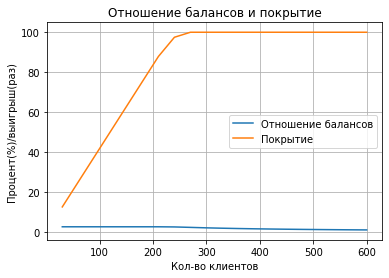

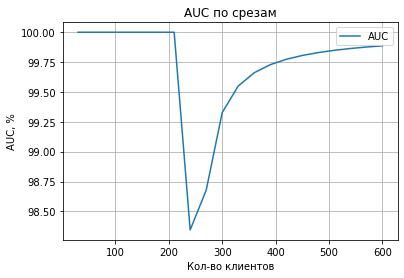

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1              0          60                60      100.000000     25.104603   
2              0          90                90      100.000000     37.656904   
3              0         120               120      100.000000     50.209205   
4              0         150               150      100.000000     62.761506   
5              0         180               180      100.000000     75.313808   
6              0         210               210      100.000000     87.866109   
7              0         240               233       97.083333     97.489540   
8              0         270               239       88.518519    100.000000   
9              0         300               239       79.666667    100.000000   
10             0         330               239       72.424242    100.000000   
11             0         360               239       66.388889    100.000000   
12             0         390               239       61.282051    100.000000   
13             0         420               239       56.904762    100.000000   
14             0         450               239       53.111111    100.000000   
15             0         480               239       49.791667    100.000000   
16             0         510               239       46.862745    100.000000   
17             0         540               239       44.259259    100.000000   
18             0         570               239       41.929825    100.000000   
19             0         600               239       39.833333    100.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.606695  100.000000  
6      38.362761             2.606695  100.000000  
7      38.362761             2.530666   98.344574  
8      38.362761             2.307407   98.677284  
9      38.362761             2.076667   99.327800  
10     38.362761             1.887879   99.549405  
11     38.362761             1.730556   99.661122  
12     38.362761             1.597436   99.728449  
13     38.362761             1.483333   99.773458  
14     38.362761             1.384444   99.805667  
15     38.362761             1.297917   99.829858  
16     38.362761             1.221569   99.848693  
17     38.362761             1.153704   99.863773  
18     38.362761             1.092982   99.876120  
19     38.362761             1.038333   99.886415

In [57]:
# Метрика отношение балансов для трейна

tr_table_cover_1 = final_model.balance_cover_1(X_train, y_train, step=30, end=600)
tr_table_cover_1

Всего записей в выборке:  268
Всего таргетов в выборке:  103


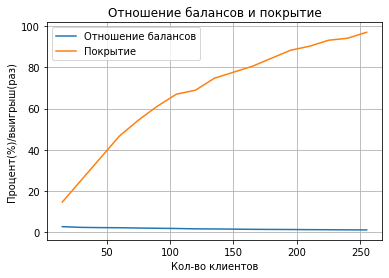

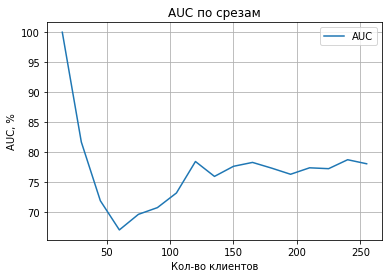

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                15      100.000000     14.563107   
1              0          30                26       86.666667     25.242718   
2              0          45                37       82.222222     35.922330   
3              0          60                48       80.000000     46.601942   
4              0          75                56       74.666667     54.368932   
5              0          90                63       70.000000     61.165049   
6              0         105                69       65.714286     66.990291   
7              0         120                71       59.166667     68.932039   
8              0         135                77       57.037037     74.757282   
9              0         150                80       53.333333     77.669903   
10             0         165                83       50.303030     80.582524   
11             0         180                87       48.333333     84.466019   
12             0         195                91       46.666667     88.349515   
13             0         210                93       44.285714     90.291262   
14             0         225                96       42.666667     93.203883   
15             0         240                97       40.416667     94.174757   
16             0         255               100       39.215686     97.087379   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.432836             2.601942  100.000000  
1      38.432836             2.255016   81.730769  
2      38.432836             2.139374   71.959459  
3      38.432836             2.081553   67.100694  
4      38.432836             1.942783   69.689850  
5      38.432836             1.821359   70.811287  
6      38.432836             1.709847   73.248792  
7      38.432836             1.539482   78.485197  
8      38.432836             1.484070   76.007613  
9      38.432836             1.387702   77.687500  
10     38.432836             1.308856   78.335292  
11     38.432836             1.257605   77.388456  
12     38.432836             1.214239   76.363060  
13     38.432836             1.152288   77.437736  
14     38.432836             1.110162   77.293282  
15     38.432836             1.051618   78.783073  
16     38.432836             1.020369   78.109677

In [58]:
# Метрика отношение балансов для валидации

te_table_cover_1 = final_model.balance_cover_1(X_valid, y_valid, step=15, end=250)
te_table_cover_1

#### Процентность таргета в бакетах

Всего записей в выборке:  623
Всего таргетов в выборке:  239


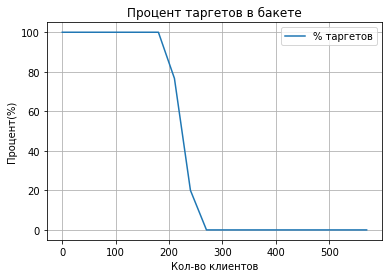

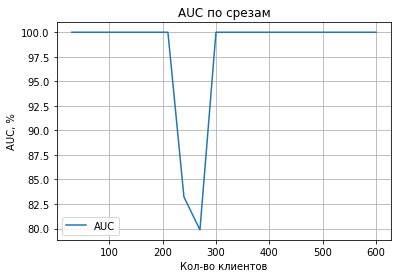

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1             30          60                30      100.000000     12.552301   
2             60          90                30      100.000000     12.552301   
3             90         120                30      100.000000     12.552301   
4            120         150                30      100.000000     12.552301   
5            150         180                30      100.000000     12.552301   
6            180         210                30      100.000000     12.552301   
7            210         240                23       76.666667      9.623431   
8            240         270                 6       20.000000      2.510460   
9            270         300                 0        0.000000      0.000000   
10           300         330                 0        0.000000      0.000000   
11           330         360                 0        0.000000      0.000000   
12           360         390                 0        0.000000      0.000000   
13           390         420                 0        0.000000      0.000000   
14           420         450                 0        0.000000      0.000000   
15           450         480                 0        0.000000      0.000000   
16           480         510                 0        0.000000      0.000000   
17           510         540                 0        0.000000      0.000000   
18           540         570                 0        0.000000      0.000000   
19           570         600                 0        0.000000      0.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.606695  100.000000  
6      38.362761             2.606695  100.000000  
7      38.362761             1.998466   83.229814  
8      38.362761             0.521339   79.861111  
9      38.362761             0.000000  100.000000  
10     38.362761             0.000000  100.000000  
11     38.362761             0.000000  100.000000  
12     38.362761             0.000000  100.000000  
13     38.362761             0.000000  100.000000  
14     38.362761             0.000000  100.000000  
15     38.362761             0.000000  100.000000  
16     38.362761             0.000000  100.000000  
17     38.362761             0.000000  100.000000  
18     38.362761             0.000000  100.000000  
19     38.362761             0.000000  100.000000

In [59]:
# Метрика процента таргета для трейна

tr_table_cover_2 = final_model.balance_cover_2(X_train, y_train, step=30, end=600)
tr_table_cover_2

Всего записей в выборке:  268
Всего таргетов в выборке:  103


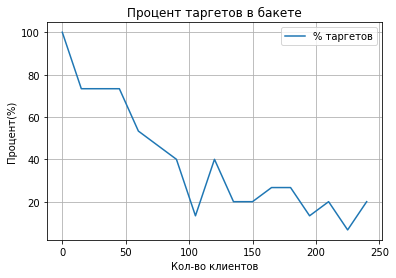

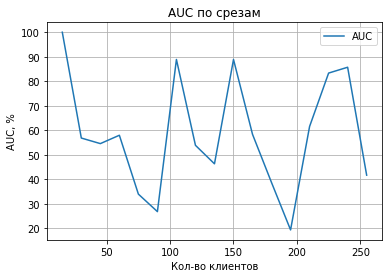

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                15      100.000000     14.563107   
1             15          30                11       73.333333     10.679612   
2             30          45                11       73.333333     10.679612   
3             45          60                11       73.333333     10.679612   
4             60          75                 8       53.333333      7.766990   
5             75          90                 7       46.666667      6.796117   
6             90         105                 6       40.000000      5.825243   
7            105         120                 2       13.333333      1.941748   
8            120         135                 6       40.000000      5.825243   
9            135         150                 3       20.000000      2.912621   
10           150         165                 3       20.000000      2.912621   
11           165         180                 4       26.666667      3.883495   
12           180         195                 4       26.666667      3.883495   
13           195         210                 2       13.333333      1.941748   
14           210         225                 3       20.000000      2.912621   
15           225         240                 1        6.666667      0.970874   
16           240         255                 3       20.000000      2.912621   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.432836             2.601942  100.000000  
1      38.432836             1.908091   56.818182  
2      38.432836             1.908091   54.545455  
3      38.432836             1.908091   57.954545  
4      38.432836             1.387702   33.928571  
5      38.432836             1.214239   26.785714  
6      38.432836             1.040777   88.888889  
7      38.432836             0.346926   53.846154  
8      38.432836             1.040777   46.296296  
9      38.432836             0.520388   88.888889  
10     38.432836             0.520388   58.333333  
11     38.432836             0.693851   38.636364  
12     38.432836             0.693851   19.318182  
13     38.432836             0.346926   61.538462  
14     38.432836             0.520388   83.333333  
15     38.432836             0.173463   85.714286  
16     38.432836             0.520388   41.666667

In [60]:
# Метрика процента таргета для валидации

te_table_cover_2 = final_model.balance_cover_2(X_valid, y_valid, step=15, end=250)
te_table_cover_2

## Этап калибровки

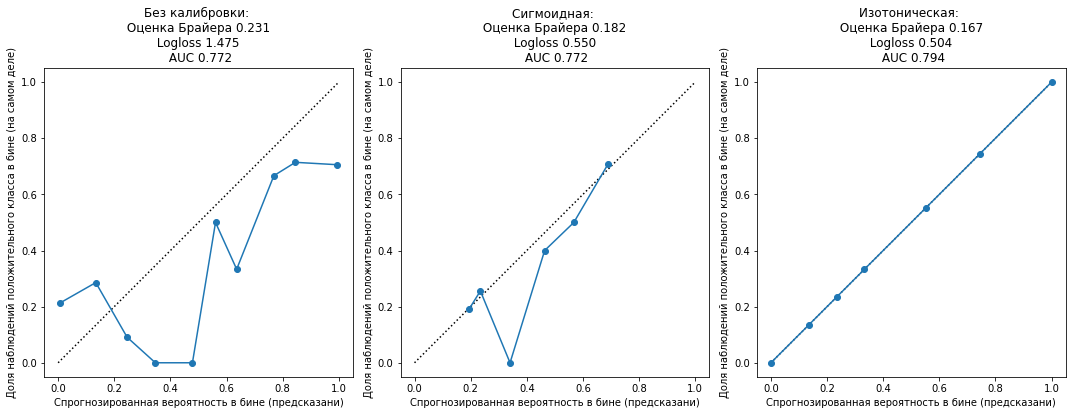

In [61]:
# Калибровка на валидации

final_model.calibration(X_valid, y_valid, n_bins=10)

### Формирование базового скора, сигмоидной калибровки и изотонической

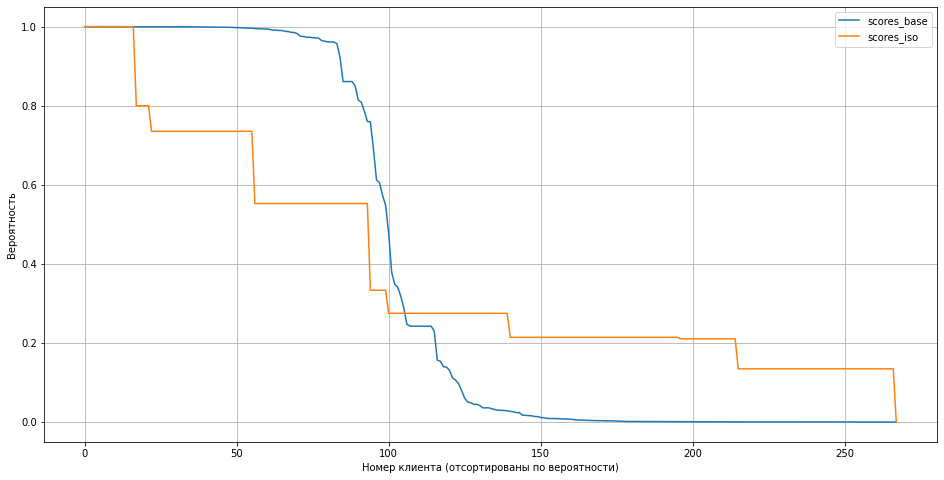

scores_base  scores_sigm  scores_iso  target
0    1.000000e+00     0.698128    1.000000       1
1    1.000000e+00     0.698128    1.000000       1
2    1.000000e+00     0.698128    1.000000       1
3    1.000000e+00     0.698128    1.000000       1
4    1.000000e+00     0.698128    1.000000       1
..            ...          ...         ...     ...
263  1.134246e-07     0.194969    0.134615       1
264  4.376050e-08     0.194969    0.134615       0
265  5.152269e-09     0.194969    0.134615       0
266  3.697898e-09     0.194969    0.134615       1
267  3.853948e-10     0.194969    0.000000       0

[268 rows x 4 columns]

In [62]:
# Выбор калибровки и сравнение с базовым скором

scores = final_model.calibration_compare(X_valid, y_valid, calib_compare='scores_iso')
scores

## Сохранение пиклов

In [63]:
final_model.get_pickles(
                columns=True,
                prep_pipe=True,
                model=True,
                calibration=True,
                type_calibration='iso',
                path='final_results')

'Все атрибуты сохранены!'

## Интерпретация модели

In [64]:
# Shap интерпретация

# задаем класс
c_shap = PlotShap(model=final_model.model, sample=final_model.prep_pipe.transform(X_train))
# обучаем
c_shap.fit_shap()

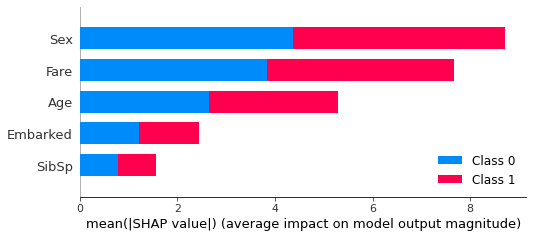

In [65]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [66]:
c_shap.create_shap_report(path_base='./shap_report')

In [67]:
# PDP-ICE интерпретация

# Задаем необходимые факторы для анализа, в нужном нам порядке
feats = features[:5]

# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=final_model.model, X=final_model.prep_pipe.transform(X_train),main_features=feats)

Sex


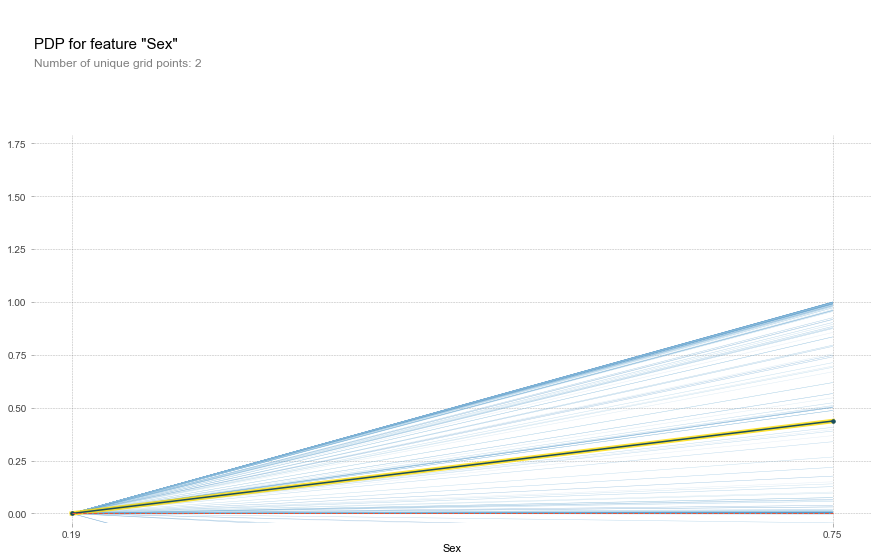

Fare


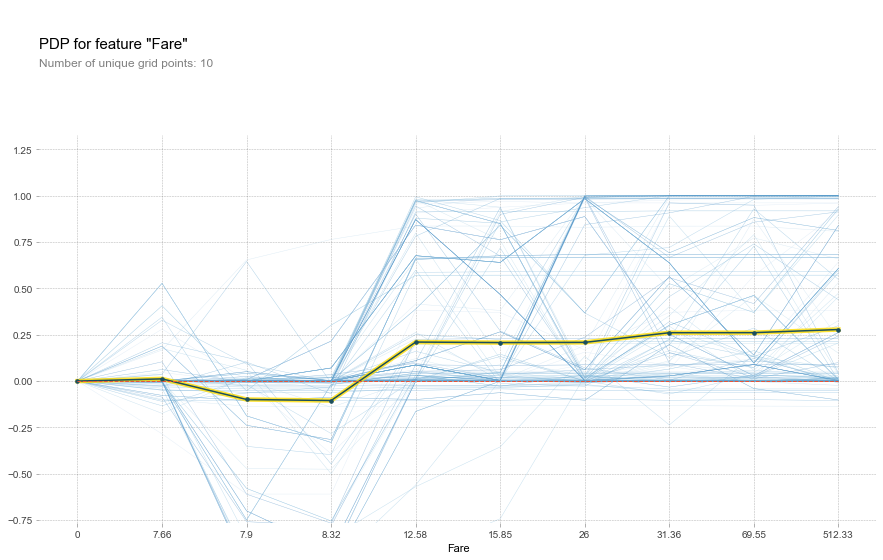

Age


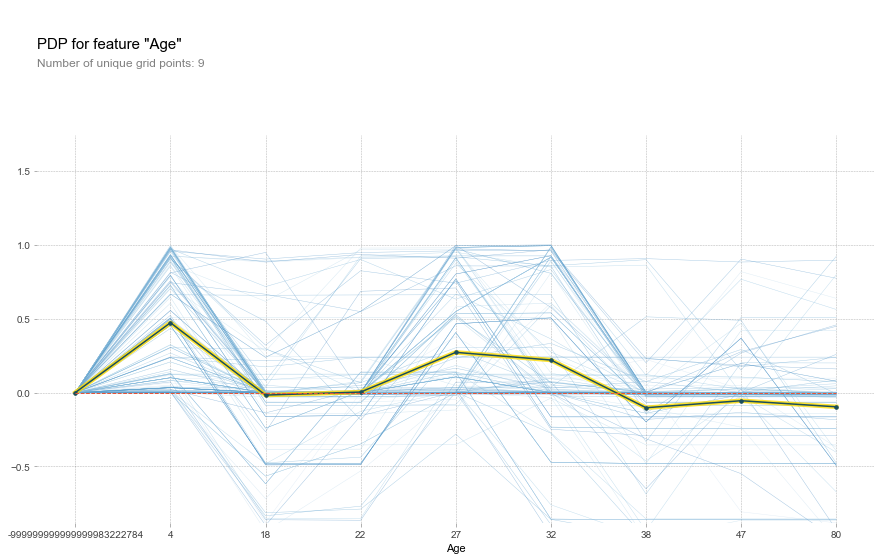

SibSp


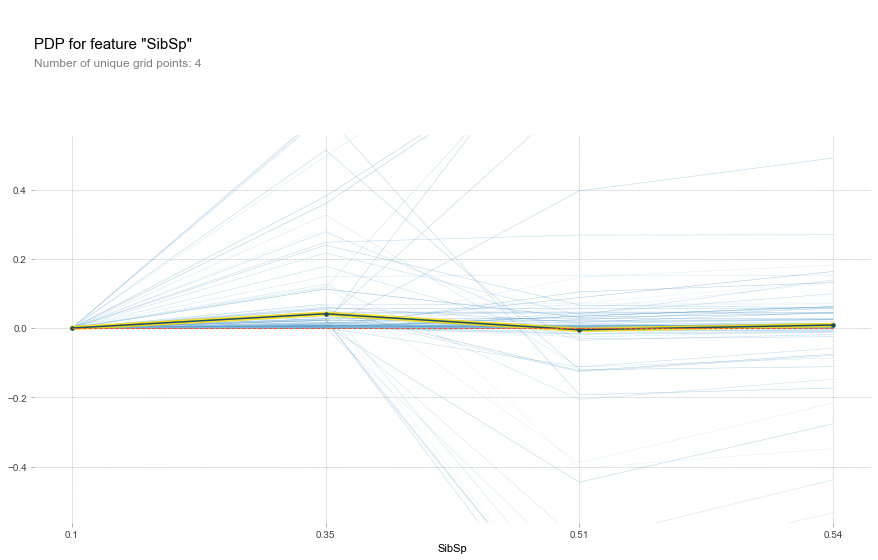

Embarked


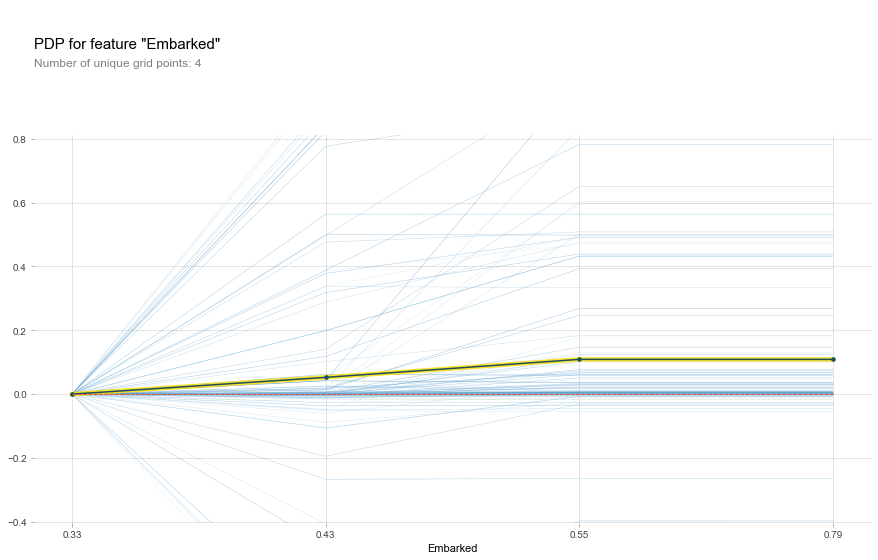

In [68]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Age'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


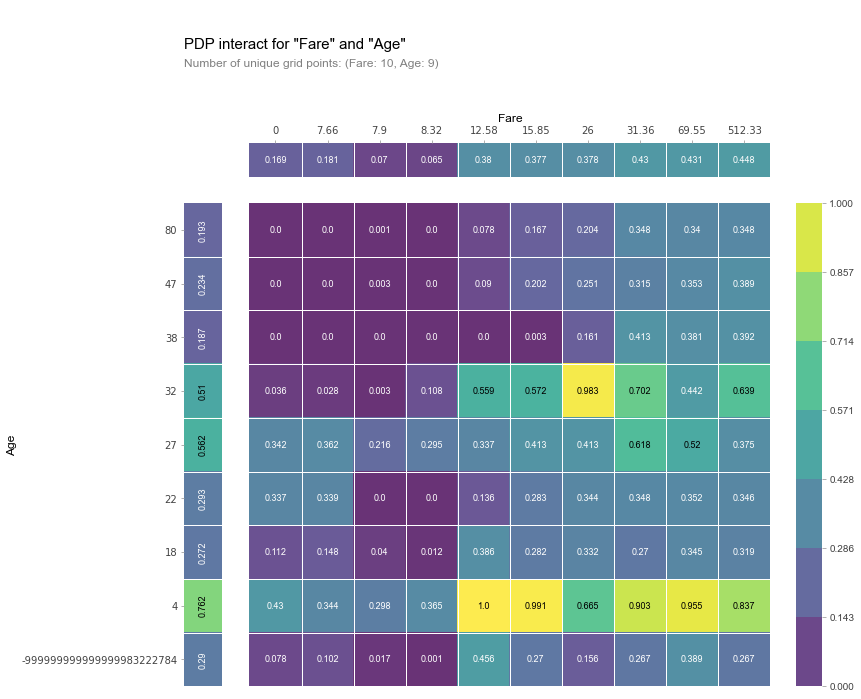

In [69]:
pdp_plot.create_interact_plot(features=['Fare','Age'], save=True)

In [70]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.
